#  Проект: Разработка моделей машинного обучения, прогнозирующих удой коровы и рассчитывающих вероятность получить вкусное молоко

## 1. Введение

Вы работаете в IT-компании, которая выполняет на заказ проекты по машинному обучению. К вам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».

Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!

Поэтому он просит вас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Вам нужно создать две прогнозные модели для отбора бурёнок в поголовье:
- Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
- Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).


С помощью модели нужно отобрать коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

### 1.1. Цель исследования

Создать 2 модели машинного обучения, одна из которых будет прогнозировать возможный удой коровы, а другая - рассчитывать вероятность получения вкусного молока от коровы.

Эти модели помогут Заказчику (фермеру) управлять рисками и принимать объективное решение о покупке коров у "ЭкоФермы".

### 1.2. Ход исследования

1. Загрузка данных и первый взгляд на них;
2. Предобработка данных: поиск и исправление ошибок в исходных данных;
3. Исследовательский анализ данных: описание и визуализация представленной информации, поиск закономерностей;
4. Создание моделей линейной регрессии и прогноз целевого признака по лучшей из них;
5. Создание модели логистической регрессии и прогноз целевого признака;
6. Выводы.

## 2. Загрузка данных

In [ ]:
!pip install phik

     |████████████████████████████████| 686 kB 2.1 MB/s eta 0:00:01


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from scipy import stats
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, \
    accuracy_score, recall_score, precision_score, confusion_matrix, precision_recall_curve

import phik

In [ ]:
pd.set_option('display.float_format', '{:.3f}'.format)

- Общий взгляд на данные о стаде фермера на текущий момент:

In [ ]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep='\;', decimal=',', engine='python')
ferma_main.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.200,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.580,3.076,вкусно,более_2_лет
1,2,5529,12.800,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.540,3.079,вкусно,менее_2_лет
2,3,5810,14.000,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.590,3.074,не вкусно,более_2_лет
3,4,5895,12.400,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.400,3.075,не вкусно,более_2_лет
4,5,5302,12.800,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.730,3.073,вкусно,менее_2_лет


- Общий взгляд на данные об именах отцов коров стаде фермера:

In [ ]:
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep='\;', engine='python')
ferma_dad.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


- Общий взгляд на данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой:

In [ ]:
cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep='\;', decimal=',', engine='python')
cow_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.580,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.540,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.590,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.400,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.640,3.074,более_2_лет


Колонки в исходных данных требуют переименования:

In [ ]:
ferma_main = ferma_main.rename(columns={
    'Удой, кг': 'milk_yield',
    'ЭКЕ (Энергетическая кормовая единица)': 'energy_feed_unit',
    'Сырой протеин, г': 'raw_protein',
    'СПО (Сахаро-протеиновое соотношение)': 'sugar_protein_ratio',
    'Порода': 'breed',
    'Тип пастбища': 'pasture_type',
    'порода папы_быка': 'dad_breed',
    'Жирность,%': 'fat_content',
    'Белок,%': 'protein',
    'Вкус молока': 'milk_taste',
    'Возраст': 'age'
})

ferma_dad = ferma_dad.rename(columns={
    'Имя Папы': 'dad_name'
})

cow_buy = cow_buy.rename(columns={
    'Порода': 'breed',
    'Тип пастбища': 'pasture_type',
    'порода папы_быка': 'dad_breed',
    'Имя_папы': 'dad_name',
    'Текущая_жирность,%': 'fat_content',
    'Текущий_уровень_белок,%': 'protein',
    'Возраст': 'age'
})

print(ferma_main.columns)
print('-' * 100)
print(ferma_dad.columns)
print('-' * 100)
print(cow_buy.columns)

Index(['id', 'milk_yield', 'energy_feed_unit', 'raw_protein',
       'sugar_protein_ratio', 'breed', 'pasture_type', 'dad_breed',
       'fat_content', 'protein', 'milk_taste', 'age'],
      dtype='object')
----------------------------------------------------------------------------------------------------
Index(['id', 'dad_name'], dtype='object')
----------------------------------------------------------------------------------------------------
Index(['breed', 'pasture_type', 'dad_breed', 'dad_name', 'fat_content',
       'protein', 'age'],
      dtype='object')


- Просмотр данных о рассматриваемых DataFrame:

In [ ]:
print(ferma_main.info())
print('-' * 100)
print(ferma_dad.info())
print('-' * 100)
print(cow_buy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   634 non-null    int64  
 1   milk_yield           634 non-null    int64  
 2   energy_feed_unit     634 non-null    float64
 3   raw_protein          634 non-null    int64  
 4   sugar_protein_ratio  634 non-null    float64
 5   breed                634 non-null    object 
 6   pasture_type         634 non-null    object 
 7   dad_breed            634 non-null    object 
 8   fat_content          634 non-null    float64
 9   protein              634 non-null    float64
 10  milk_taste           634 non-null    object 
 11  age                  634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB
None
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.

### Выводы

Файл с исходными данными открыт и изучен.

Пропуски в данных отсутствуют. Некоторые типы данных можно изменить.<br>
Требуется проведение предобработки данных.

##  3. Предобработка данных

### 3.1. Изменение типов данных

Не требуется.

### 3.2. Пропущенные значения

На предыдущем этапе с помощью метода info() было определено, что пропущенные значения отсутствуют.

### 3.3. Поиск и удаление дубликатов

#### Явные дубликаты

In [ ]:
print('Количество явных дубликатов в ferma_main:', ferma_main.duplicated().sum())
print('Количество явных дубликатов в ferma_dad:', ferma_dad.duplicated().sum())
print('Количество явных дубликатов в cow_buy:', cow_buy.duplicated().sum())

Количество явных дубликатов в ferma_main: 5
Количество явных дубликатов в ferma_dad: 0
Количество явных дубликатов в cow_buy: 4


Доля дубликатов в ferma_main составляет менее 1%, в cow_buy - 20% от и без того маленькой выборки.

Удаляем дубликаты:

In [ ]:
ferma_main = ferma_main.drop_duplicates()
print(ferma_main.shape)

cow_buy = cow_buy.drop_duplicates()
print(cow_buy.shape)

(629, 12)
(16, 7)


#### Неявные дубликаты

In [ ]:
for c in ferma_main[['breed', 'pasture_type', 'dad_breed', 'milk_taste', 'age']]:
    print(ferma_main[c].unique())

print('-' * 100)

print(ferma_dad['dad_name'].unique())

print('-' * 100)

for c in cow_buy[['breed', 'pasture_type', 'dad_breed', 'dad_name', 'age']]:
    print(cow_buy[c].unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']
['Равнинное' 'Равнинные' 'Холмистое']
['Айдиал' 'Соверин' 'Айдиалл']
['вкусно' 'не вкусно']
['более_2_лет' 'менее_2_лет']
----------------------------------------------------------------------------------------------------
['Буйный' 'Соловчик' 'Барин' 'Геркулес']
----------------------------------------------------------------------------------------------------
['Вис Бик Айдиал' 'РефлешнСоверинг']
['холмистое' 'равнинное']
['Айдиал' 'Соверин']
['Геркулес' 'Буйный' 'Барин' 'Соловчик']
['более_2_лет' 'менее_2_лет']


В DataFrame ferma_main приведем типы пастбища в единообразному виду с DataFrame cow_buy:

In [ ]:
ferma_main['pasture_type'] = ferma_main['pasture_type'].replace('Равнинные', 'Равнинное').str.lower()
ferma_main['pasture_type'].unique()

array(['равнинное', 'холмистое'], dtype=object)

Внесем изменения в названия пород:

In [ ]:
ferma_main['breed'] = ferma_main['breed'].replace({'Вис Бик Айдиал': 'Айдиал', 'РефлешнСоверинг':'Соверин'})
print(ferma_main['breed'].unique())

cow_buy['breed'] = cow_buy['breed'].replace({'Вис Бик Айдиал': 'Айдиал', 'РефлешнСоверинг':'Соверин'})
print(cow_buy['breed'].unique())

['Айдиал' 'Соверин']
['Айдиал' 'Соверин']


In [ ]:
ferma_main['dad_breed'] = ferma_main['dad_breed'].replace('Айдиалл', 'Айдиал')
ferma_main['dad_breed'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

### 3.4. Выводы

Проведена предобработка данных:

- пропуски в данных не обнаружены;
- выявлены и удалены явные и неявные дубликаты;
- наименования уникальных значений приведены к единообразию.



## 4. Исследовательский анализ данных

Описание данных:

In [ ]:
display(ferma_main.describe())

display(cow_buy.describe())

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,fat_content,protein
count,629.000,629.000,629.000,629.000,629.000,629.000,629.000
mean,315.000,6188.750,14.544,1923.364,0.913,3.604,3.076
std,181.721,1644.795,1.306,182.956,0.032,0.169,0.003
min,1.000,5204.000,10.900,1660.000,0.840,2.990,3.069
25%,158.000,5751.000,13.500,1771.000,0.890,3.590,3.074
50%,315.000,6133.000,14.700,1888.000,0.930,3.650,3.076
75%,472.000,6501.000,15.600,2062.000,0.940,3.720,3.077
max,629.000,45616.000,16.800,2349.000,0.960,3.750,3.085


,fat_content,protein
count,16.000,16.000
mean,3.572,3.068
std,0.142,0.011
min,3.340,3.046
25%,3.415,3.059
50%,3.585,3.074
75%,3.692,3.077
max,3.770,3.081


### 4.1. Графики признаков

In [ ]:
ferma_main_numerical_data = ['milk_yield', 'energy_feed_unit', 'raw_protein', 'sugar_protein_ratio', 'fat_content', 'protein']

ferma_main_categorical_data = ['breed', 'pasture_type', 'dad_breed', 'milk_taste', 'age']

cow_buy_numerical_data = ['fat_content', 'protein']

cow_buy_categorical_data = ['breed', 'pasture_type', 'dad_breed', 'dad_name', 'age']

Посмотрим на графики распределения количественных признаков DataFrame ferma_main:

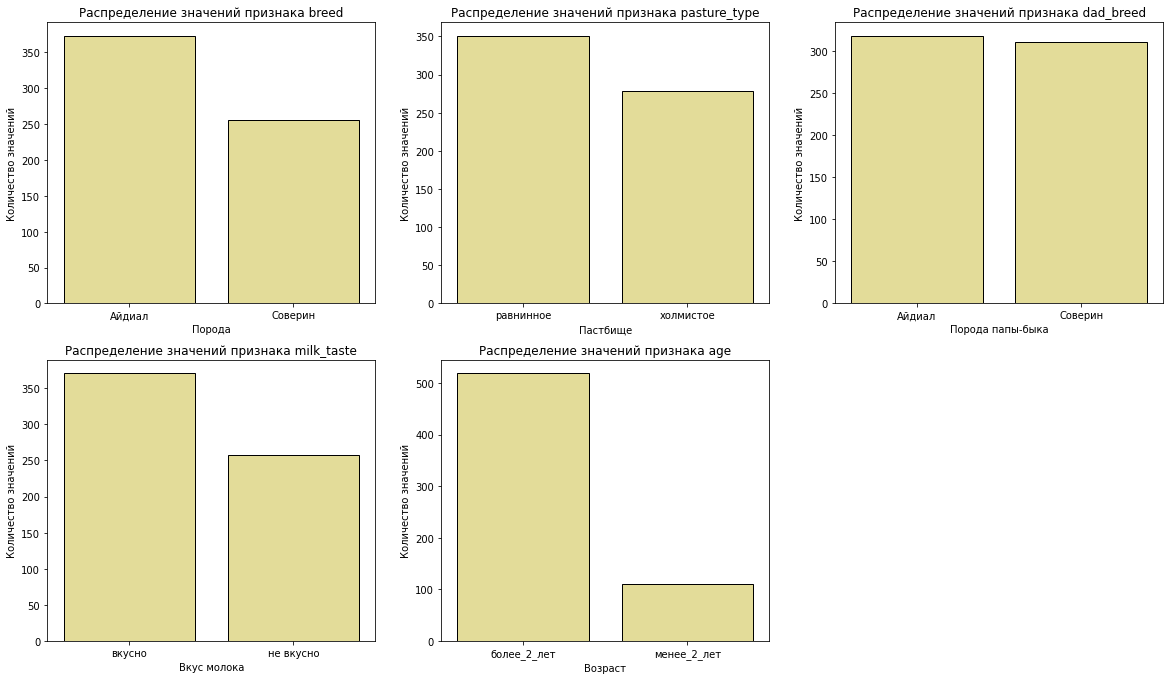

In [ ]:
fig = plt.figure(figsize=(20,30))

x_labels_1 = ['Порода', 'Пастбище', 'Порода папы-быка', 'Вкус молока', 'Возраст']
total_axes = len(ferma_main_categorical_data)
subplt = 1
for n, c in enumerate(ferma_main[ferma_main_categorical_data]):
    ax = fig.add_subplot(total_axes, 3, subplt, xlabel=x_labels_1[n])
    sns.barplot(x=ferma_main[c].unique(), y=ferma_main[c].value_counts(), color='khaki', ec='black')
    subplt += 1
    plt.title(f'Распределение значений признака {c}')
    plt.ylabel('Количество значений')
pass

Посмотрим на графики распределения количественных признаков DataFrame ferma_dad:

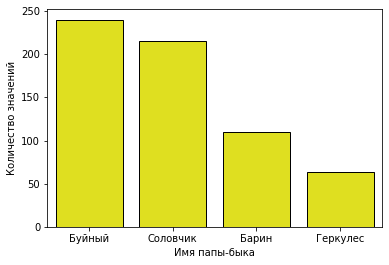

In [ ]:
sns.barplot(x=ferma_dad['dad_name'].unique(),
    y=ferma_dad['dad_name'].value_counts(),
    color='yellow',
    ec='black',
    )

plt.xlabel('Имя папы-быка')
plt.ylabel('Количество значений')
pass

Графики распределения количественных признаков DataFrame cow_buy:

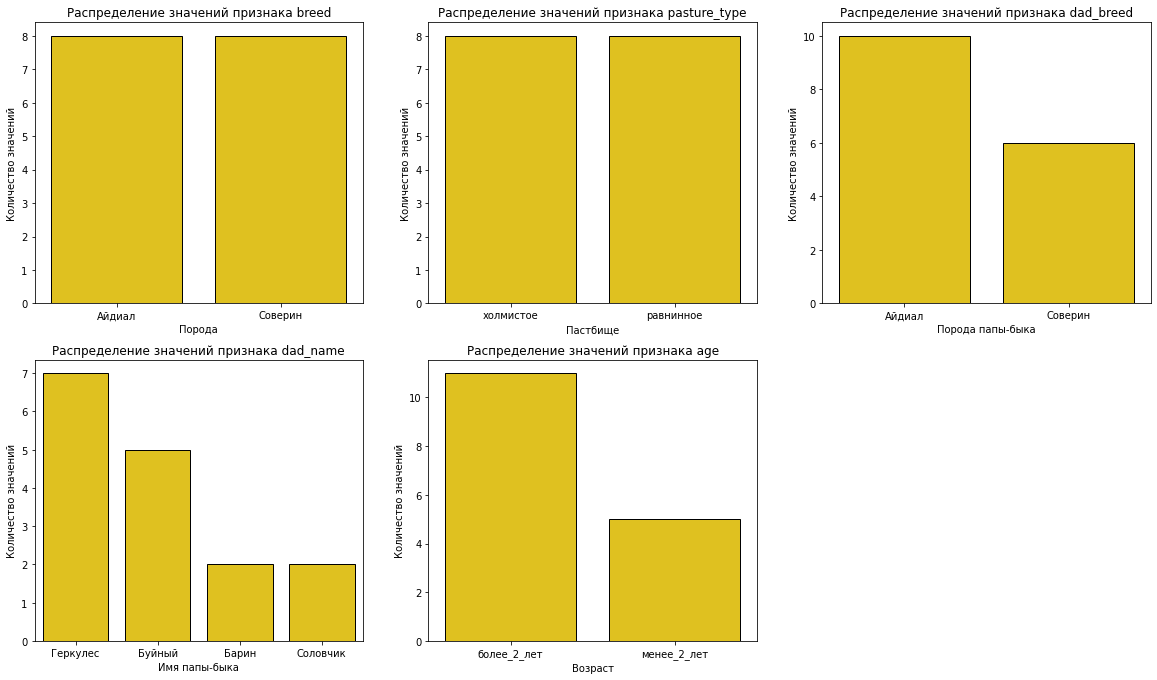

In [ ]:
fig = plt.figure(figsize=(20,30))

x_labels_2 = ['Порода', 'Пастбище', 'Порода папы-быка', 'Имя папы-быка', 'Возраст']
total_axes = len(cow_buy_categorical_data)
subplt = 1
for n, c in enumerate(cow_buy[cow_buy_categorical_data]):
    ax = fig.add_subplot(total_axes, 3, subplt, xlabel=x_labels_2[n])
    sns.barplot(x=cow_buy[c].unique(), y=cow_buy[c].value_counts(), color='gold', ec='black')
    subplt += 1
    plt.title(f'Распределение значений признака {c}')
    plt.ylabel('Количество значений')
pass

У фермера больше коров породы Айдиал, чем коров породы Соверин; преимущественно пасутся в районах холмистой местности. Возраст животных в основном более 2 лет и дают вкусное молоко. Самое частовстречающеесся имя папы-быка - Барин.

У 'ЭкоФермы', судя по небольшому количеству данных, также больше коров старше 2-х лет, однако, количество коров породы Айдиал равно количеству коров породы Соверин, количество холмистых и равнинных пастбищ одинаково. Самое частовстречающеесся имя папы-быка - Буйный.


Построим графики для количественных признаков (гистограммы и boxplot'ы):

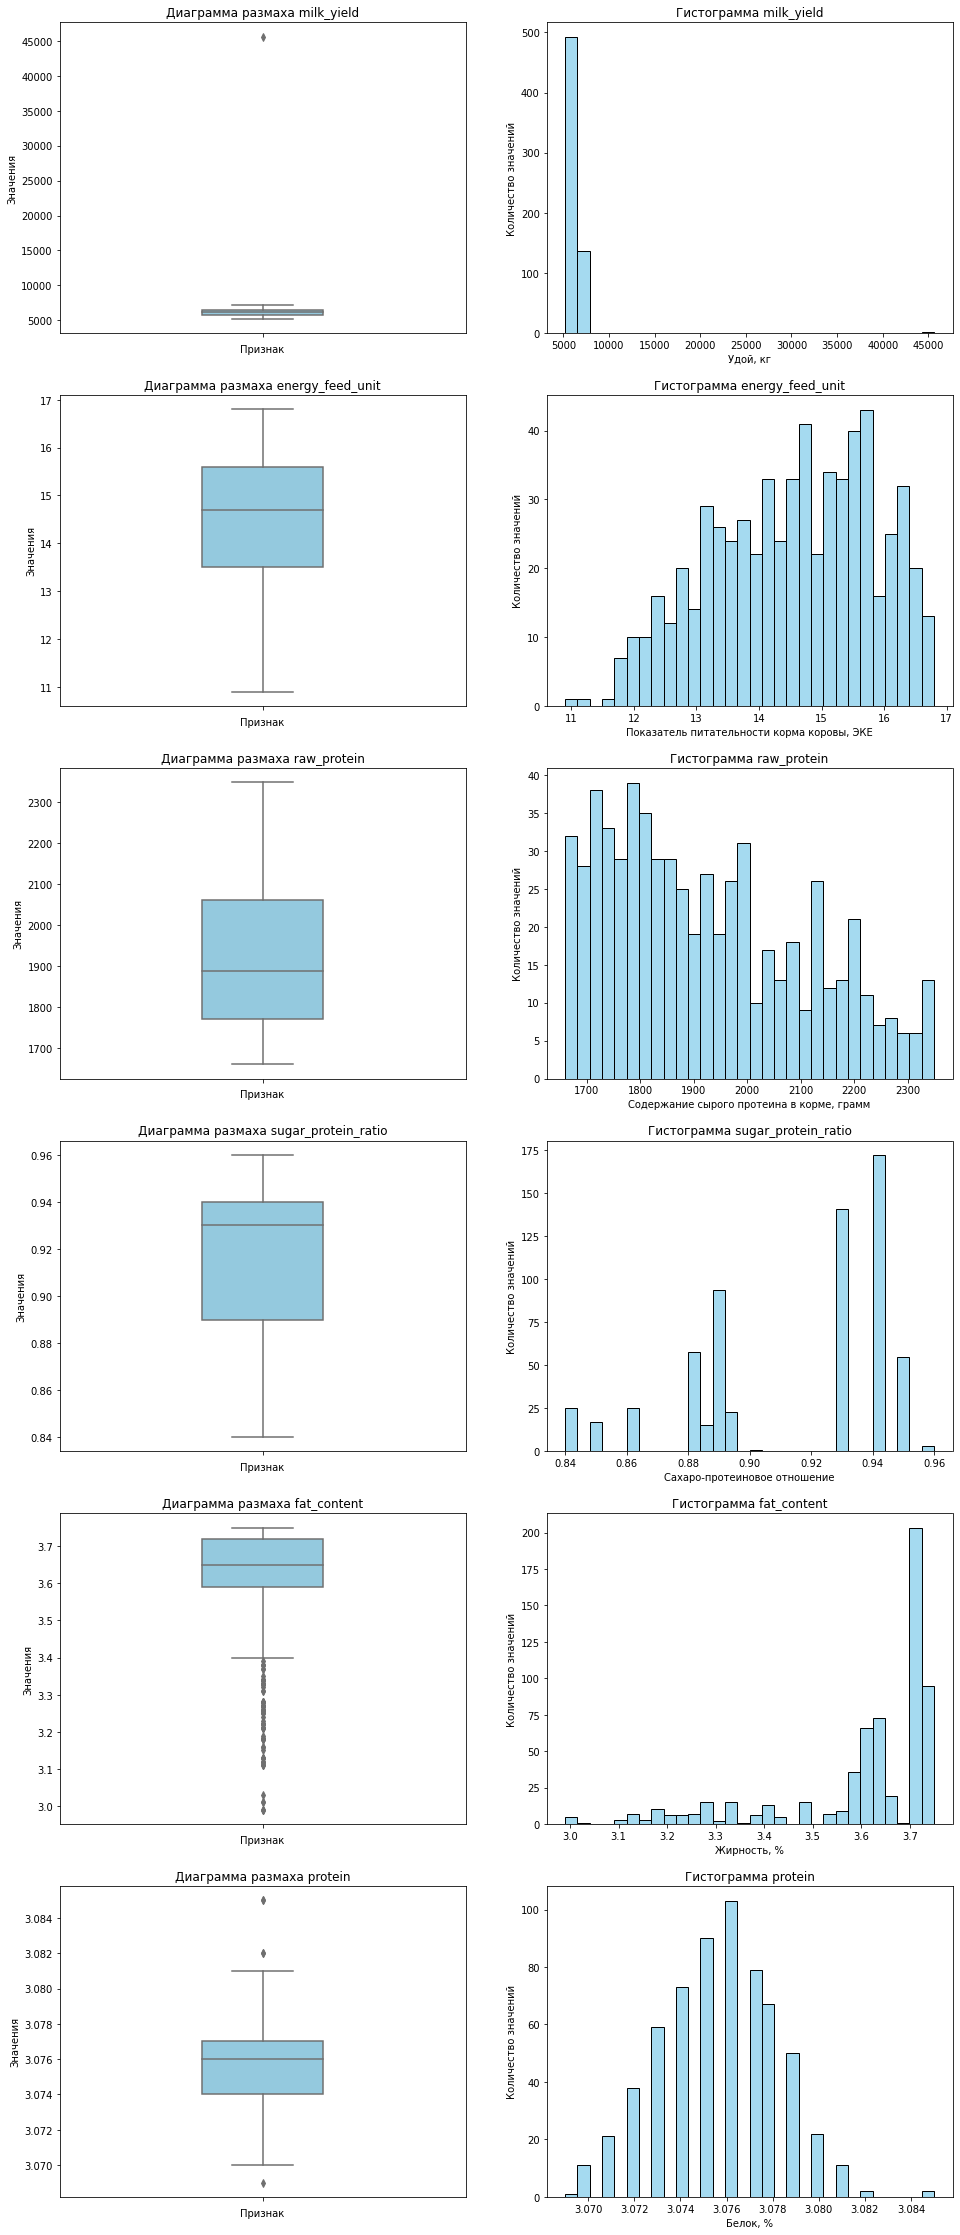

In [ ]:
x_labels_3 = ['Удой, кг','Показатель питательности корма коровы, ЭКЕ', \
       'Содержание сырого протеина в корме, грамм','Сахаро-протеиновое отношение','Жирность, %', 'Белок, %']

fig = plt.figure(figsize=(16,40))

total_axes = len(ferma_main_numerical_data)
subplt = 1
for n, c in enumerate(ferma_main[ferma_main_numerical_data]):
    ax = fig.add_subplot(total_axes, 2, subplt)
    sns.boxplot(y=ferma_main[c], color='skyblue', width=.3)
    subplt += 1
    plt.title(f'Диаграмма размаха {c}')
    plt.xlabel('Признак')
    plt.ylabel('Значения')
    ax = fig.add_subplot(total_axes, 2, subplt)
    sns.histplot(ferma_main[c], color='skyblue', ec='black', bins=30)
    subplt += 1
    plt.title(f'Гистограмма {c}')
    plt.xlabel(x_labels_3[n])
    plt.ylabel('Количество значений')
pass

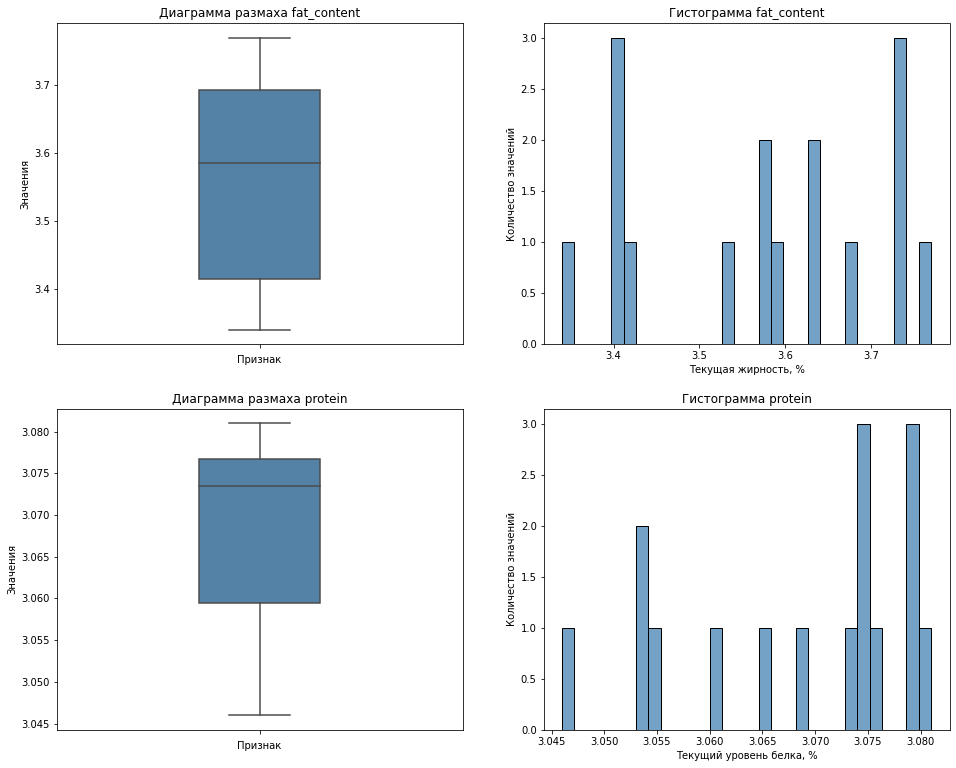

In [ ]:
x_labels_4 = ['Текущая жирность, %','Текущий уровень белка, %']

fig = plt.figure(figsize=(16,13))

total_axes = len(cow_buy_numerical_data)
subplt = 1
for n, c in enumerate(cow_buy[cow_buy_numerical_data]):
    ax = fig.add_subplot(total_axes, 2, subplt)
    sns.boxplot(y=cow_buy[c], color='steelblue', width=.3)
    subplt += 1
    plt.title(f'Диаграмма размаха {c}')
    plt.xlabel('Признак')
    plt.ylabel('Значения')
    ax = fig.add_subplot(total_axes, 2, subplt)
    sns.histplot(cow_buy[c], color='steelblue', bins=30)
    subplt += 1
    plt.title(f'Гистограмма {c}')
    plt.xlabel(x_labels_4[n])
    plt.ylabel('Количество значений')
pass

Видим выбросы в данных в fat_content  и protein, аномальное значение в milk_yield (DataFrame ferma_main).

In [ ]:
ferma_main.query('milk_yield > 40000')

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat_content,protein,milk_taste,age
16,17,45616,11.500,1675,0.930,Айдиал,холмистое,Айдиал,3.220,3.076,вкусно,более_2_лет


Вероятно, техническая ошибка в удое данной коровы. Заменил медианным значением:

In [ ]:
ferma_main.loc[16, 'milk_yield'] = ferma_main['milk_yield'].median()
ferma_main[16:17]

,id,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat_content,protein,milk_taste,age
16,17,6133.000,11.500,1675,0.930,Айдиал,холмистое,Айдиал,3.220,3.076,вкусно,более_2_лет


Распределение после удаления выброса в milk_yield:

Text(0, 0.5, 'Количество значений')

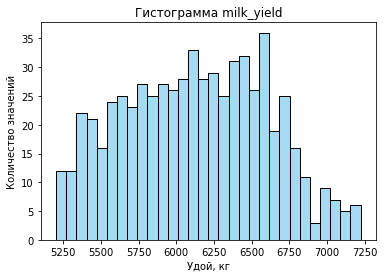

In [ ]:
sns.histplot(ferma_main['milk_yield'], color='skyblue', ec='black', bins=30)
plt.title(f'Гистограмма milk_yield')
plt.xlabel('Удой, кг')
plt.ylabel('Количество значений')

По гистограммам распределения занчений признаков можно отметить следующее.

Распределения значений не очень похожи на нормальные (за исключением  столбца 'Белок' в ferma_main).

Выборки небольшие (особенно данные из cow_buy), можно видеть 'пики' на графиках.

Жирность 3.7% в данных фермера встречается в более чем 200 случаях - с большим отрывом от других значений.
<br><br>

Можно удалить выбросы, выявленные на диаграммах размаха. Эти выбросы могут повдиять на метрику MSE / RMSE. Однако, удаление повлечет за собой уменьшение DataFrame ferma_main еще более, чем на 13%. Оставим пока эти данные.

### 4.2. Выводы

На данном этапе были рассмотрены признаки исходных датасетов.

У фермера больше коров породы Айдиал, чем коров породы Соверин; преимущественно пасутся в районах холмистой местности. Возраст животных в основном более 2 лет и дают вкусное молоко. Самое частовстречающеесся имя папы-быка - Барин.

У 'ЭкоФермы', судя по небольшому количеству данных, также больше коров старше 2-х лет, однако, количество коров породы Айдиал равно количеству коров породы Соверин, количество холмистых и равнинных пастбищ одинаково. Самое частовстречающеесся имя папы-быка - Буйный.

<br><br>
Диаграммы размаха показали наличие выбросов в данных в fat_content и protein. Строка с аномальным значением в milk_yield (DataFrame ferma_main) удалена.

<br><br>
По гистограммам распределения занчений признаков можно отметить следующее.

Распределения значений не очень похожи на нормальные (за исключением  столбца 'Белок' в ferma_main).

Выборки небольшие (особенно данные из cow_buy), можно видеть 'пики' на графиках.

Жирность 3.7% в данных фермера встречается в более чем 200 случаях - с большим отрывом от других значений.
<br><br>

Можно удалить выбросы, выявленные на диаграммах размаха. Эти выбросы могут повлиять на метрику MSE / RMSE. Однако, удаление повлечет за собой уменьшение DataFrame ferma_main еще более, чем на 13%. Оставим пока эти данные.

В дальнешем нужно объединить таблицы ferma_main и ferma_dad.


## 5. Корреляционный анализ признаков в ferma_main

### 5.1. Матрицы корреляций

Построим общую матрицу корреляций признаков данного датафрейма (предварительно удалив столбец id):

In [ ]:
ferma_main = ferma_main.drop('id', axis=1)

Судя по ранее рассмотренным распределениям количественных признаков,  они имеют ненормальное распределение. Исключение - 'Белок'(нормальное распределение). В таком случае используем коэффициенты корреляции Спирмена:

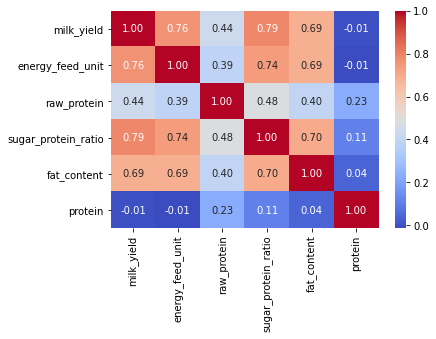

In [ ]:
sns.heatmap(ferma_main.corr(method='spearman'), cmap='coolwarm', annot=True, fmt='.2f')
pass

Отдельно посмотрим (на всякий случай) на корреляцию неномально распределенного milk_yield и нормально распределенного protein:

In [ ]:
ferma_main['milk_yield'].corr(ferma_main['protein'])

0.0029687103813305507

Матрицы корреляций с учетом подгрупп (также используем коэффициенты корреляции Спирмена) :

In [ ]:
ferma_main_categorical_data

['breed', 'pasture_type', 'dad_breed', 'milk_taste', 'age']

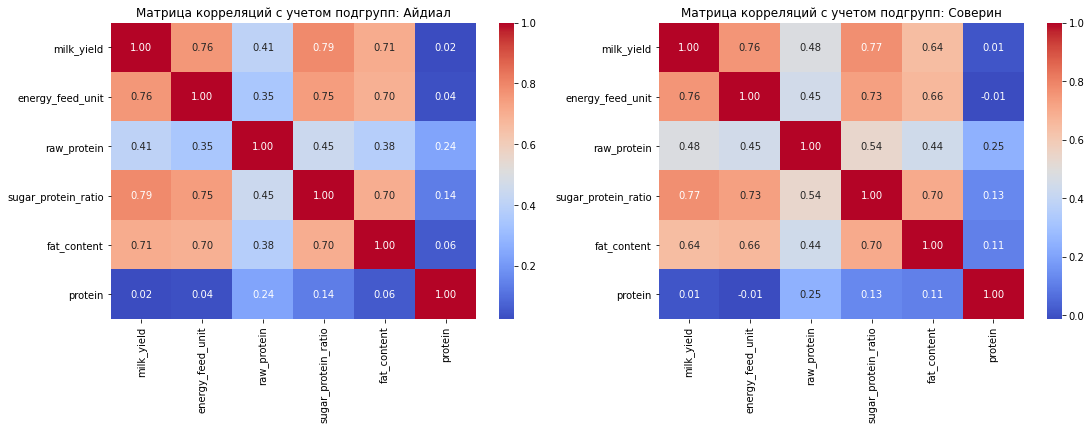

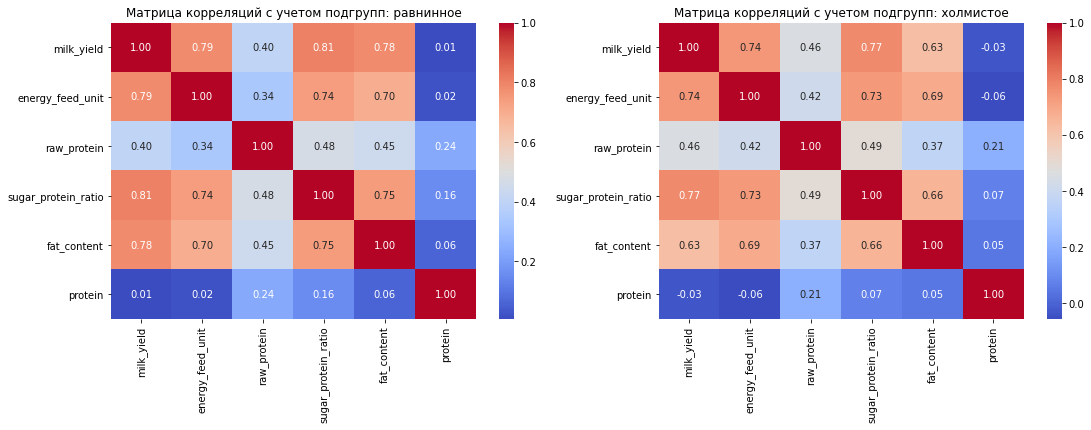

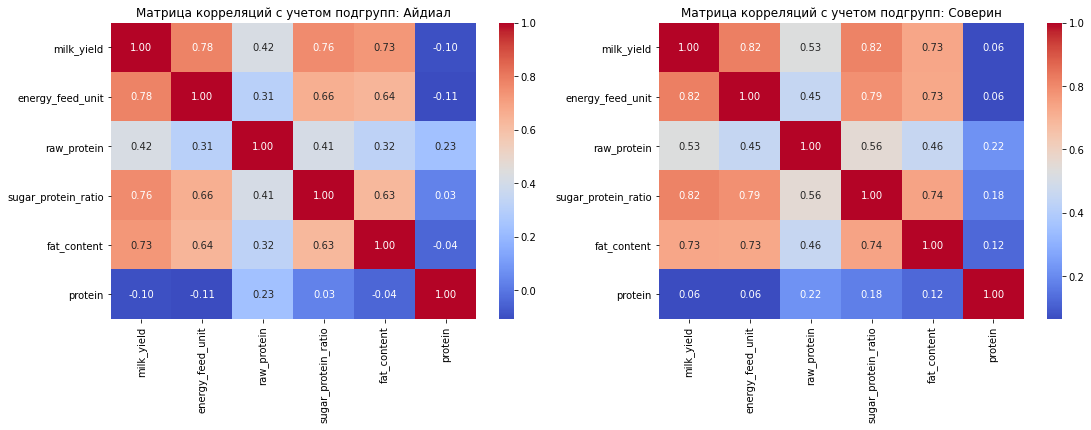

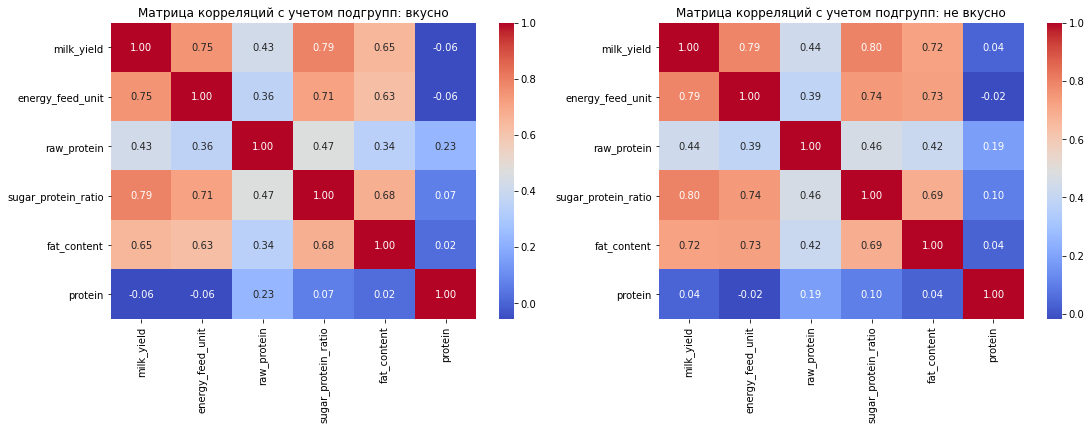

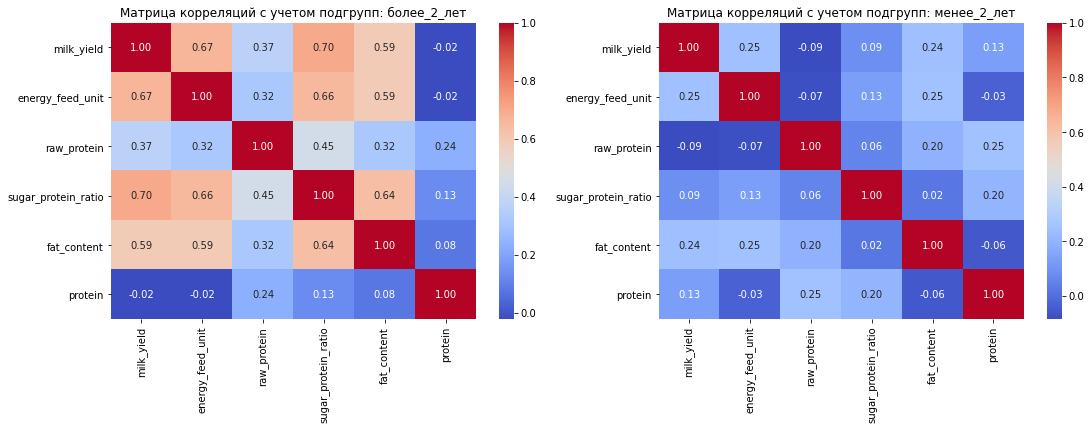

In [ ]:
def make_corr_matrix(categorical):
    fig = plt.figure(figsize=(18,12))

    total_axes = len(ferma_main[categorical].unique())
    subplt = 1
    for c in ferma_main[categorical].unique():
        ax = fig.add_subplot(total_axes, 2, subplt)
        sns.heatmap(
        ferma_main[ferma_main[categorical] == c][ferma_main_numerical_data].corr(method='spearman'),
        cmap='coolwarm',
        annot=True,
        fmt='.2f',
        )
        subplt += 1
        plt.title(f'Матрица корреляций с учетом подгрупп: {c}')

for d in ferma_main_categorical_data:
    make_corr_matrix(d)

### 5.2. Диаграммы рассеяния

Построим диаграммы рассеяния для признака Удой и всех количественных признаков с учётом значения категориальных признаков.

In [ ]:
ferma_main_categorical_data

['breed', 'pasture_type', 'dad_breed', 'milk_taste', 'age']

In [ ]:
'''def make_scatter(categorical):
    fig = plt.figure(figsize=(20,40))

    total_axes = len(ferma_main_numerical_data[1:])
    subplt = 1
    for n, c in enumerate(ferma_main[ferma_main_numerical_data[1:]]):
        ax = fig.add_subplot(total_axes, 3, subplt, ylabel=ferma_main_numerical_data[1:][n])
        sns.scatterplot(data=ferma_main, x='milk_yield', y=c, hue=categorical, alpha=0.7)
        subplt += 1
        plt.title(f'Диаграмма рассеяния для milk_yield и {c}')
        plt.xlabel('Удой, кг')

    pass

for d in ferma_main_categorical_data:
    make_scatter(d)'''
pass

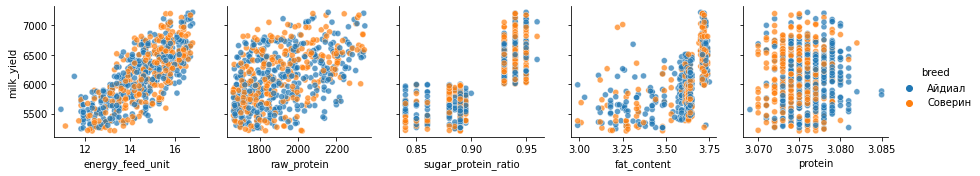

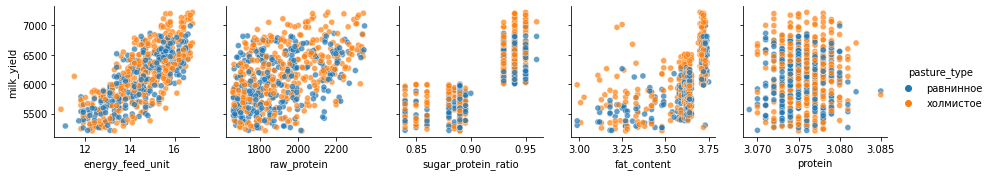

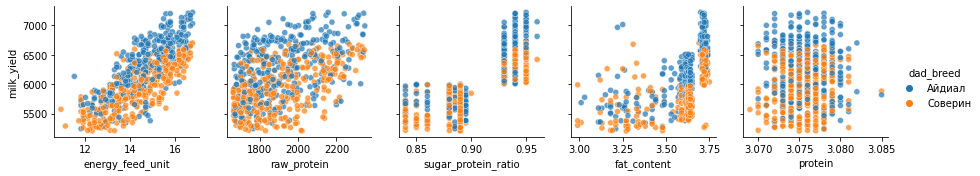

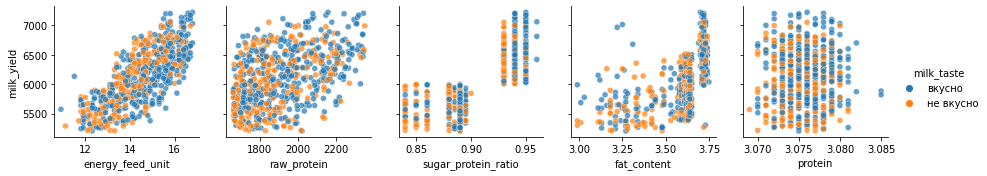

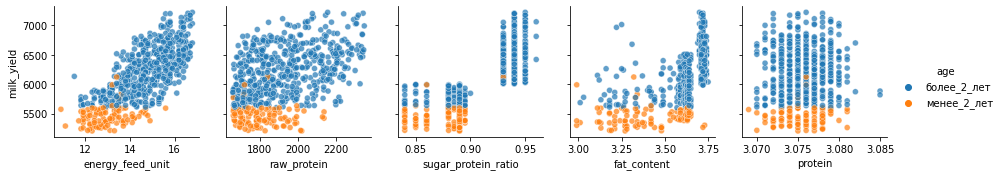

In [ ]:
for category in ferma_main_categorical_data:
    g = sns.PairGrid(ferma_main, hue=category, x_vars=ferma_main_numerical_data[1:], y_vars='milk_yield')
    g.map(sns.scatterplot, alpha=0.7)
    g.add_legend()
pass

Дополнительное исследование на мультиколлинеарность с помощью VIF (Variance Inflation Factor):

In [ ]:
# Испольщованием milk_yield в качестве целевой переменной
y, X = dmatrices('milk_yield ~ energy_feed_unit+raw_protein+sugar_protein_ratio+fat_content+protein', \
                 data=ferma_main, return_type='dataframe')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,1568395.905,Intercept
1,2.553,energy_feed_unit
2,1.344,raw_protein
3,2.579,sugar_protein_ratio
4,1.879,fat_content
5,1.079,protein


Значения >5 указывают на мультиколлинеарность между независимыми переменными. В данном случае значения находятся в пределах 1-5,  что означает умеренную зависимость между признаками, что допустимо. <br>
Значение Intersept игнорируем, он не имеет значения для модели.

### 5.3. Выводы

- корреляции без выделения подгрупп:
наибольшая корреляция целевого признака 'Удой' происходит с Показателем питательности кормов коровы, Сахаро-протеиновым отношением, Содержанием жира;


- корреляции с выделением подгрупп признаков:
корреляции с целевым признаком в целом такие же, как и в общей матрице (с некоторыми различиями в цифрах каждой подгруппы), кроме признака age. Здесь в погруппе 'менее 2 лет' корреляция между признаками слабая, но чаще почти отсутствует;


- диаграммы рассеяния: <br>
-- на диаграммах рассеяния прослеживается связь milk_yield и energy_feed_unit (ЭКЕ), однако она выглядит 'не совсем линейной';<br>
-- на диаграмме рассеяния milk_yield и fat_content видно 'уплотнение' в районе высокой жирности; <br>
-- диаграмма рассеяния milk_yield и sugar_protein_ratio выглядит необычно - чем-то даже похожа на логарифический рост (если попытаться соединить участки диаграммы линией), однако коэффициент корреляции Пирсона показывает сильную зависимость;<br>
-- диаграммы рассеяния целевого и входных признаков с учетом возраста коровы имеют четкие границы: более молодые коровы дают меньший удой в сочетании с другими количественными признаками; <br>
-- также обращает на себя внимание, что если порода папы-быка - Айдиал, значения удоя в сочетании с другими признаками выше, чем для породы папы-быка Соверин.

<br><br>
Целевой признак имеет следующую взамосвязь с входными (использована шкала Чеддока):
- показатель питательности корма коровы (energy_feed_unit) - высокая корреляция;
- содержание сырого протеина в корме (raw_protein) - умеренная корреляция;
- сахаро-протеиновое отношение (sugar_protein_ratio) -  высокая корреляция;
- содержание жиров в молоке (fat_content) - заметная корреляция;
- содержание белка в молоке (protein) - зависимость отсутствует.
<br><br>

Однако, четкая линейная зависимость целевого признака с входными отсутствует. Эту проблему нужно устранять.
<br><br>

Как правило, о мультиколлинеарности говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю.  В настоящем датасете femra_main такие коэффициенты отсутствуют (в т.ч. в матрицах корреляций, учитывающих подгруппы признаков). <br>
Также был проведен дополнительный анализ на наличие мультиколлинеарности (VIF): мультиколлинеарность не обнаружена.

**Изучение зависимости ЭКЕ-Удой (energy_feed_unit - milk_yield) и ЭКЕ^2-Удой (energy_feed_unit^2 - milk_yield)**

Реализуем метод линейной регрессии для данных признаков, в т.ч. построив графики с указанием значения R^2.

In [ ]:
def create_lr(x_lr, y_lr, c):

    #линия регрессии
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_lr, y_lr)
    line = slope * x_lr + intercept

    fig = plt.figure(figsize=(10,4))

    plt.scatter(x_lr, y_lr, s=10)
    plt.plot(x_lr, line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
    plt.plot([], [], ' ', label='R_sq = '+'{:.4f}'.format(r_value**2))

    plt.grid(True)
    plt.title(f'График линейной регрессии зависимости Удой-{c}')
    plt.legend(fontsize=12)
    plt.xlabel(c)
    plt.ylabel('Удой')
    plt.show()

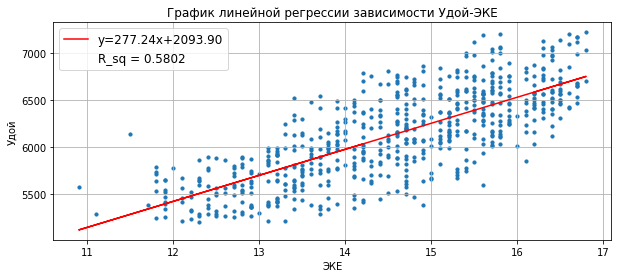

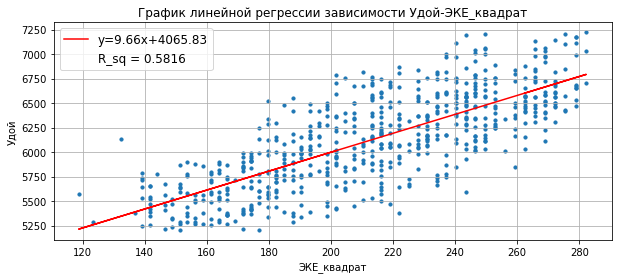

In [ ]:
x_lr = ferma_main['energy_feed_unit'].astype('float')
x_lr2 = (ferma_main['energy_feed_unit'] ** 2).astype('float')
y_lr = ferma_main['milk_yield'].astype('float')

create_lr(x_lr, y_lr, 'ЭКЕ')
create_lr(x_lr2, y_lr, 'ЭКЕ_квадрат')

R_sq (r в квадрате) признака Удой-ЭКЕ^2 больше, чем r_sq зависимости признаков Удой-ЭКЕ. Значит зависимость Удой-ЭКЕ^2 лучше описывается прямой.

## 6. Обучение модели линейной регрессии

### 6.1. Первая модель линейной регрессии

#### 6.1.1. Подготовка данных, обучение модели

Разделение DataFrame на 2 группы: целевой признак и входные признаки:

In [ ]:
X = ferma_main.drop('milk_yield', axis=1)

y = ferma_main['milk_yield']

Отбор признаков для модели линейной регрессии:
<br><br><br>
На этапе исследовательсого анализа было выяснено, что целевой признак имеет:
1. высокую взамосвязь с:
- показателем питательности корма коровы (энергетическая кормовая единица, energy_feed_unit);
- сахаро-протеиновое отношением в корме коровы (sugar_protein_ratio);
2. заметную взаимосвязь с содержанием жиров в молоке (fat_content).
<br><br>
3. Умеренная взаимосвязь целевого признака наблюдается с содержанием сырого протеина в корме (raw_protein).
4. Зависимость признаком содержание белка в молоке (protein) отсутствует.
<br><br>

Учитывая, что корреляция признака raw_protein с целевым ниже, чем  признака sugar_protein_ratio с целевым, а также то, что в обоих входных признаках учитывается протеин в корме, оставим лишь 1 признак - sugar_protein_ratio.<br>
Также исключим признак protein, у которого отсутствует линейная зависимость с удоем.<br>
Исключим fat_content, который, хоть и имеет заметную взаимосвязь с целевым признаком, все же является критерием качества молока и едва ли влияет на удой.

Также, судя по диаграммам рассеяния, подгруппы breed и milk_taste не оказывают влияния на удой.

In [ ]:
X = ferma_main.drop(['milk_yield', 'raw_protein', 'protein', 'breed', 'milk_taste', 'fat_content'], axis=1)
X.head(3)

,energy_feed_unit,sugar_protein_ratio,pasture_type,dad_breed,age
0,14.200,0.890,равнинное,Айдиал,более_2_лет
1,12.800,0.890,равнинное,Соверин,менее_2_лет
2,14.000,0.885,холмистое,Соверин,более_2_лет


Разбивка данных на тренировочную и тестовую выборки,<bR>
кодирование категориальных признаки с помощью OneHotEncoder,<br>
масштабироване количественных признаков с помощью StandardScaler:

In [ ]:
def make_model(X, y, cat_col_names, num_col_names):
    '''
    Разбивка данных на тренировочную и тестовую выборки,
    кодирование категориальных признаки с помощью OneHotEncoder,
    масштабироване количественных признаков с помощью StandardScaler:
    '''
    RANDOM_STATE = 42

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        random_state=RANDOM_STATE
    )

    encoder = OneHotEncoder(drop='first', sparse=False)
    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    X_test_ohe = encoder.transform(X_test[cat_col_names])
    encoder_col_names = encoder.get_feature_names()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])

    '''Объединение в один DataFrame для дальнейшего обучения'''
    df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    df_X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    #print('Размер таблицы отмасштабированных признаков X_train:', df_X_train_scaled.shape)
    #print('Размер таблицы кодированных признаков X_train:', df_X_train_ohe.shape)
    df_X_train_merged = df_X_train_scaled.merge(df_X_train_ohe, right_index=True, left_index=True)
    #print('Размер таблицы объединенных признаков X_train:', df_X_train_merged.shape, '\n')

    df_X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
    df_X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    #print('Размер таблицы отмасштабированных признаков X_test:', df_X_test_scaled.shape)
    #print('Размер таблицы кодированных признаков X_test:', df_X_test_ohe.shape)
    df_X_test_merged = df_X_test_scaled.merge(df_X_test_ohe, right_index=True, left_index=True)
    #print('Размер таблицы объединенных признаков X_test:', df_X_test_merged.shape)

    '''Обучение модели линейной регрессии'''
    model_lr  = LinearRegression()
    model_lr.fit(df_X_train_merged, y_train)

    predictions = model_lr.predict(df_X_test_merged)

    return y_test, encoder_col_names, predictions, model_lr, df_X_train_merged, X_train_ohe, X_train_scaled, encoder, scaler, y_train

In [ ]:
cat_col_names1 = ['pasture_type', 'dad_breed', 'age']
num_col_names1 = ['energy_feed_unit', 'sugar_protein_ratio']

make_model(X, y, cat_col_names1, num_col_names1)

y_test1 = make_model(X, y, cat_col_names1, num_col_names1)[0]
predictions1 = make_model(X, y, cat_col_names1, num_col_names1)[2]

print('\n', 'Первое предсказанное значение:', predictions[1].round(1), \
        '\n', 'Первое настоящее значение из тестовой выборки:', y_test.reset_index(drop=True)[1])

Наименования колонок encoder:

In [ ]:
make_model(X, y, cat_col_names1, num_col_names1)[1]

array(['x0_холмистое', 'x1_Соверин', 'x2_менее_2_лет'], dtype=object)

####  6.1.2. Оценка качества модели на тестовой выборке

 Расчет R²:

In [ ]:
r2 = r2_score(y_test1, predictions1)

Анализ остатков с помощью графиков:

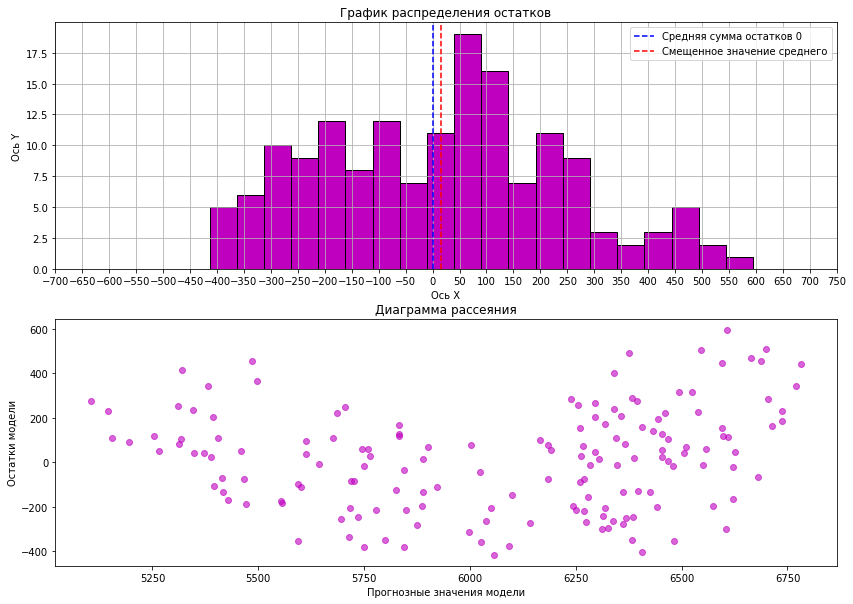

In [ ]:
def make_residuals_schedule(y_test, pred):
    residuals = y_test - pred

    ax = plt.subplot(2, 1, 1)
    residuals.hist(bins=20, color='m', ec='black', figsize=(14,10))
    plt.title('График распределения остатков')
    plt.xlabel('Ось X')
    plt.ylabel('Ось Y')
    plt.xticks(np.arange(-700, 800, 50))

    plt.axvline (x=0, color='b', linestyle='--', label='Средняя сумма остатков 0')
    plt.axvline (x=residuals.mean(), color='r', linestyle='--', label='Смещенное значение среднего')
    plt.legend()

    ax = plt.subplot(2, 1, 2)
    plt.scatter(x=pred, y=residuals, alpha=0.6, color='m')

    plt.title('Диаграмма рассеяния')
    plt.xlabel('Прогнозные значения модели')
    plt.ylabel('Остатки модели')

make_residuals_schedule(y_test1, predictions1)

Диаграмма рассеяния с наложенным residplot:

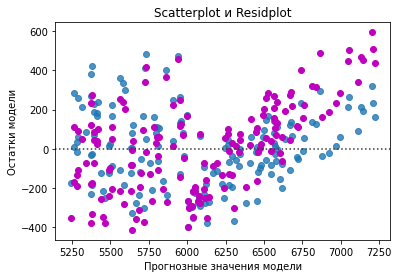

In [ ]:
sns.residplot(
    x=y_test1,
    y=y_test1 - predictions1,
    )
plt.scatter(
    x=y_test1,
    y=y_test1 - predictions1,
    color='m'
    )
plt.title('Scatterplot и Residplot')
plt.xlabel('Прогнозные значения модели')
plt.ylabel('Остатки модели')
pass

#### 6.1.3. Выводы по результатам

In [ ]:
print('Значение коэффициента детерминации R²:', r2)

Значение коэффициента детерминации R²: 0.8110387062582212


Значение R² показывает, что в 81,1% случаев предсказание модели ближе к истине, чем среднее значение целевого признака.

Распределение значений остатков: гистограмма смещена вправо - прогнозы меньше истинных значений; также есть выбросы в остатках.

Диаграмма рассеяния: видно, что распределение остатков - непостоянное. т.е. модель непредсказуема, а ее прогнозы - не надежны.
<br><br>
Необходимо проведение дополнительных исследований для более точной и предсказуемой работы модели: найти и добавить в модель  дополнительные признаки.


### 6.2. Вторая модель линейной регрессии

#### 6.2.1. Исключение нелинейности входных признаков к целевому

На диаграмме рассеяния Удой - Сахаро-протеиновое отношение в корме коровы видно, что существуют кластеры значений. Преобразуем признак sugar_protein_ratio в бинарный. Границу разделения можно определить на графике 'Гистограмма sugar_protein_ratio' в п.4.1 настоящего проекта - она проходит по значению 0.91.

In [ ]:
X2 = X.copy()
X2['sugar_protein_ratio'] = np.where(X2['sugar_protein_ratio'] >= 0.91, 1, 0)
X2['sugar_protein_ratio'].unique()

array([0, 1])

Создание нового признака energy_feed_unit_sq (energy_feed_unit в квадрате) для исключения нелинейности в признаке 'Показатель питательности корма коровы':

In [ ]:
X2['energy_feed_unit_sq'] = X2['energy_feed_unit'] ** 2
X2['energy_feed_unit_sq'].head()

0   201.640
1   163.840
2   196.000
3   153.760
4   163.840
Name: energy_feed_unit_sq, dtype: float64

#### 6.2.2. Подготовка данных, обучение модели

In [ ]:
X2 = X2.drop(['energy_feed_unit'], axis=1)
X2.head(3)

,sugar_protein_ratio,pasture_type,dad_breed,age,energy_feed_unit_sq
0,0,равнинное,Айдиал,более_2_лет,201.640
1,0,равнинное,Соверин,менее_2_лет,163.840
2,0,холмистое,Соверин,более_2_лет,196.000


Для разбивки данных для тренировочной и тестовой выборок, кодирования категориальных признаки с помощью OneHotEncoder, масштабирования количественных признаков с помощью StandardScaler, обучения модели используем функцию, созданную ранее:

In [ ]:
cat_col_names2 = ['sugar_protein_ratio', 'pasture_type', 'dad_breed', 'age']
num_col_names2 = ['energy_feed_unit_sq']

make_model(X2, y, cat_col_names2, num_col_names2)

y_test2 = make_model(X2, y, cat_col_names2, num_col_names2)[0]
predictions2 = make_model(X2, y, cat_col_names2, num_col_names2)[2]

Наименования колонок encoder:

In [ ]:
make_model(X2, y, cat_col_names2, num_col_names2)[1]

array(['x0_1', 'x1_холмистое', 'x2_Соверин', 'x3_менее_2_лет'],
      dtype=object)

Объединение данных в один DataFrame для дальнейшего обучения:

####  6.2.3. Оценка качества модели на тестовой выборке

 Расчет R²:

In [ ]:
r2_2 = r2_score(y_test2, predictions2)

Анализ остатков с помощью графиков:

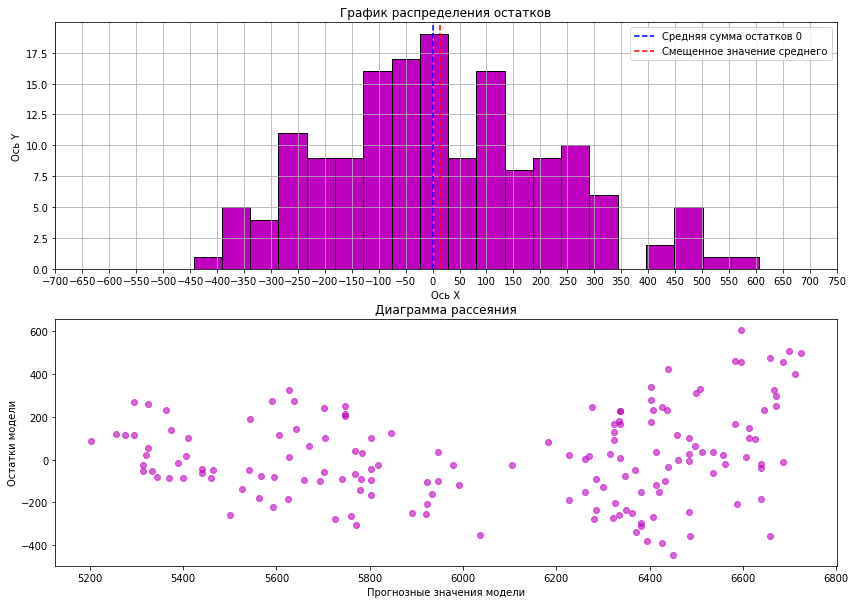

In [ ]:
make_residuals_schedule(y_test2, predictions2)

Диаграмма рассеяния с наложенным residplot:

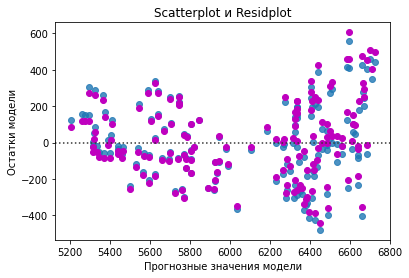

In [ ]:
sns.residplot(
    x=predictions2,
    y=y_test2 - predictions2
    )
plt.scatter(
    x=predictions2,
    y=y_test2 - predictions2,
    color='m'
    )
plt.title('Scatterplot и Residplot')
plt.xlabel('Прогнозные значения модели')
plt.ylabel('Остатки модели')
pass

#### 6.2.4. Выводы по результатам

In [ ]:
print('Значение коэффициента детерминации R²:', r2_2)

Значение коэффициента детерминации R²: 0.8375641822480836


Значение R² показывает, что в 83,8% случаев предсказание модели ближе к истине, чем среднее значение целевого признака.

Распределение значений остатков: гистограмма смещена вправо - прогнозы меньше истинных значений; также есть выбросы в остатках. Распределение стало выглядеть ближе к нормальному.

Диаграмма рассеяния: распределение остатков - ухудшилось по сравнению с первой моделью.
<br><br>
Необходимо проведение дополнительных исследований для более точной и предсказуемой работы модели.


### 6.3. Третья модель линейной регрессии

#### 6.3.1. Добавление нового признака и работа с ним

Добавление признака dad_name из DataFrame ferma_dad:

In [ ]:
X3 = X2.copy()
X3 = X3.merge(ferma_dad, how='inner', right_index=True, left_index=True)
X3.head(3)

,sugar_protein_ratio,pasture_type,dad_breed,age,energy_feed_unit_sq,id,dad_name
0,0,равнинное,Айдиал,более_2_лет,201.640,1,Буйный
1,0,равнинное,Соверин,менее_2_лет,163.840,2,Соловчик
2,0,холмистое,Соверин,более_2_лет,196.000,3,Барин


In [ ]:
X3.shape

(629, 7)

#### 6.3.2. Подготовка данных, обучение модели

Для разбивки данных для тренировочной и тестовой выборок, кодирования категориальных признаки с помощью OneHotEncoder, масштабирования количественных признаков с помощью StandardScaler, обучения модели используем функцию, созданную ранее:

In [ ]:
cat_col_names3 = ['sugar_protein_ratio', 'pasture_type', 'dad_breed', 'age', 'dad_name']
num_col_names3 = ['energy_feed_unit_sq']

make_model(X3, y, cat_col_names3, num_col_names3)

y_test3 = make_model(X3, y, cat_col_names3, num_col_names3)[0]
predictions3 = make_model(X3, y, cat_col_names3, num_col_names3)[2]

Наименование колонок encoder:

In [ ]:
encoder_col_names3 = make_model(X3, y, cat_col_names3, num_col_names3)[1]
encoder_col_names3

array(['x0_1', 'x1_холмистое', 'x2_Соверин', 'x3_менее_2_лет',
       'x4_Буйный', 'x4_Геркулес', 'x4_Соловчик'], dtype=object)

####  6.3.3. Оценка качества модели на тестовой выборке

 Расчет R²:

In [ ]:
r2_3 = r2_score(y_test3, predictions3)

Анализ остатков с помощью графиков:

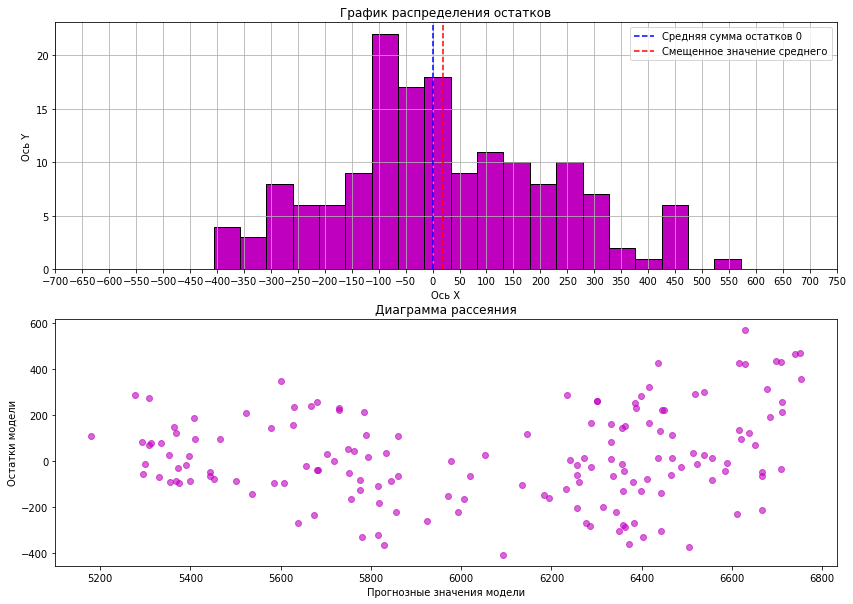

In [ ]:
make_residuals_schedule(y_test3, predictions3)

Диаграмма рассеяния с наложенным residplot:

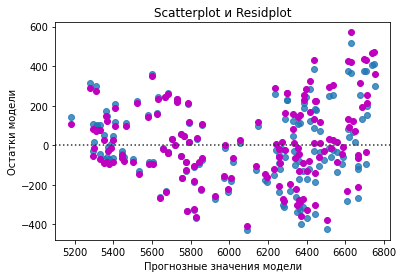

In [ ]:
sns.residplot(
    x=predictions3,
    y=y_test3 - predictions3
    )
plt.scatter(
    x=predictions3,
    y=y_test3 - predictions3,
    color='m'
    )
plt.title('Scatterplot и Residplot')
plt.xlabel('Прогнозные значения модели')
plt.ylabel('Остатки модели')
pass

#### 6.3.4. Выводы по результатам

In [ ]:
print('Значение коэффициента детерминации R²:', r2_3)

Значение коэффициента детерминации R²: 0.8526920940319298


Значение R² показывает, что в 85,3% случаев предсказание модели ближе к истине, чем среднее значение целевого признака.

Распределение значений остатков: гистограмма смещена вправо - прогнозы меньше истинных значений; количество 'пик' снова увеличилось.

Диаграмма рассеяния: распределение остатков - улучшилось по сравнению с предыдущими моделямию, т.е. модель стала более предсказуема, а ее прогнозы - боле надежны.
<br><br>

### 6.4. Сравнение качества трех моделей

Сопоставление R² моделей и их остатков:

In [ ]:
print('Значение коэффициента детерминации R² первой модели:', r2.round(4))
print('Значение коэффициента детерминации R² второй модели:', r2_2.round(4))
print('Значение коэффициента детерминации R² третьей модели:', r2_3.round(4))

Значение коэффициента детерминации R² первой модели: 0.811
Значение коэффициента детерминации R² второй модели: 0.8376
Значение коэффициента детерминации R² третьей модели: 0.8527


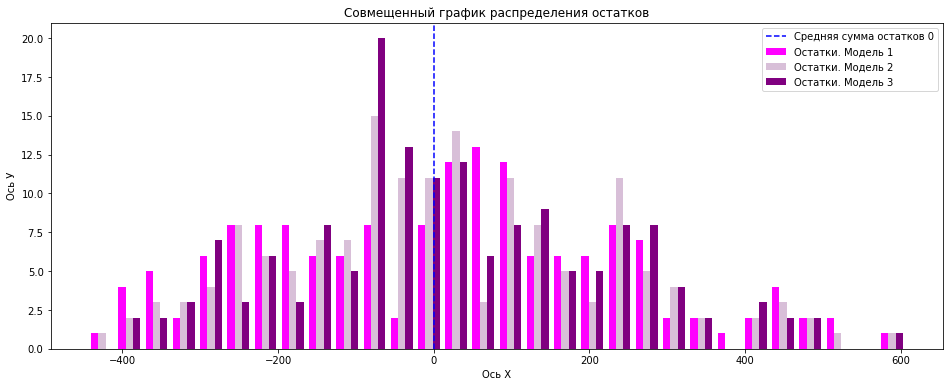

In [ ]:
plt.figure(figsize=(16,6))
plt.hist([(y_test1 - predictions1), (y_test2 - predictions2), (y_test3 - predictions3)],
         bins = 30,
         color = ['magenta', 'thistle', 'purple'],
         label=['Остатки. Модель 1', 'Остатки. Модель 2', 'Остатки. Модель 3'])

plt.axvline (x=0, color='b', linestyle='--', label='Средняя сумма остатков 0')

plt.legend()
plt.xlabel('Ось Х')
plt.ylabel('Ось У')
plt.title('Совмещенный график распределения остатков')

pass

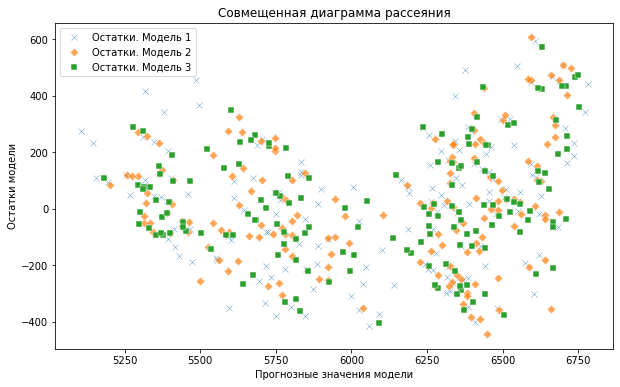

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = predictions1, y = (y_test1 - predictions1), alpha=0.7, marker='x', label='Остатки. Модель 1')
sns.scatterplot(x = predictions2, y = (y_test2 - predictions2), alpha=0.7, marker='D', label='Остатки. Модель 2')
sns.scatterplot(x = predictions3, y = (y_test3 - predictions3), alpha=1, marker='s', label='Остатки. Модель 3')


plt.title('Совмещенная диаграмма рассеяния')
plt.xlabel('Прогнозные значения модели')
plt.ylabel('Остатки модели')

pass

Оценка важности моделями того или иного признака:

1. Для первой модели наиболее значимую роль играл energy_feed_unit, sugar_protein_ratio, возраст животного и порода папы-быка.

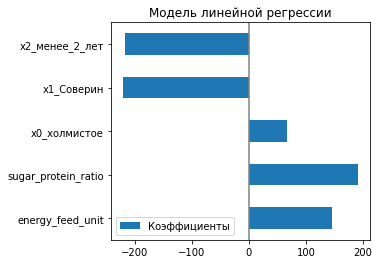

In [ ]:
model_lr1 = make_model(X, y, cat_col_names1, num_col_names1)[3]
X_train1 = make_model(X, y, cat_col_names1, num_col_names1)[4]

coefs = pd.DataFrame(
    model_lr1.coef_, columns=['Коэффициенты'], index=X_train1.columns
)

coefs.plot(kind='barh', figsize=(6, 4))
plt.title("Модель линейной регрессии")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

2. После перевода sugar_protein_ratio в категориальный признак видим, насколько он стал более значимым.

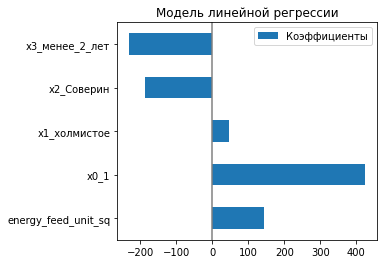

In [ ]:
model_lr2 = make_model(X2, y, cat_col_names2, num_col_names2)[3]
X_train2 = make_model(X2, y, cat_col_names2, num_col_names2)[4]

coefs = pd.DataFrame(
    model_lr2.coef_, columns=['Коэффициенты'], index=X_train2.columns
)

coefs.plot(kind='barh', figsize=(6, 4))
plt.title("Модель линейной регрессии")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

3. Добавление в модель имени папы-быка уточнило модель.

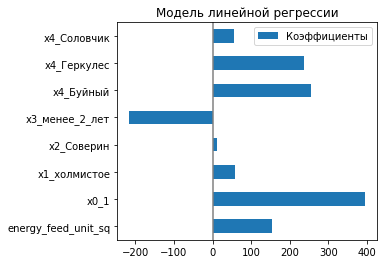

In [ ]:
model_lr3 = make_model(X3, y, cat_col_names3, num_col_names3)[3]
X_train3 = make_model(X3, y, cat_col_names3, num_col_names3)[4]

coefs = pd.DataFrame(
    model_lr3.coef_, columns=['Коэффициенты'], index=X_train3.columns
)

coefs.plot(kind='barh', figsize=(6, 4))
plt.title("Модель линейной регрессии")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Согласно коэффициенту детерминации наиболее точная модель - модель №3.

БОльшая 'средняя сумма остатков  0' наблюдается у модели №2. В целом распределение этой модели выглядит более нормальным.

Более равномерное распределение остатков по диаграмме рассеяния - у модели №3.

### 6.5. Оценка каждой модели

In [ ]:
def count_metrics(y_test, pred):
    print('Среднеквадратичная ошибка mse:', mean_squared_error(y_test, pred).round(1))
    print('Корень из среднеквадратичной ошибки rmse:', mean_squared_error(y_test, pred, squared=False).round(1))
    print('Средняя абсолютная ошибка mae:', mean_absolute_error(y_test, pred).round(1))

In [ ]:
print('Оценка первой модели:', '\n')
print(count_metrics(y_test1, predictions1))

Оценка первой модели: 

Среднеквадратичная ошибка mse: 51778.4
Корень из среднеквадратичной ошибки rmse: 227.5
Средняя абсолютная ошибка mae: 187.2
None


In [ ]:
print('Оценка второй модели:', '\n')
print(count_metrics(y_test2, predictions2))

Оценка второй модели: 

Среднеквадратичная ошибка mse: 44510.0
Корень из среднеквадратичной ошибки rmse: 211.0
Средняя абсолютная ошибка mae: 167.8
None


In [ ]:
print('Оценка третьей модели:', '\n')
print(count_metrics(y_test3, predictions3))

Оценка третьей модели: 

Среднеквадратичная ошибка mse: 40364.7
Корень из среднеквадратичной ошибки rmse: 200.9
Средняя абсолютная ошибка mae: 159.2
None


Судя по рассмотренным метрикам модель №3 - лучшая.

Найдем доверительный интервал, рассчитав квантили ошибки модели:

In [ ]:
np.quantile((y_test3 - predictions3), q=[0.05, 0.95])

array([-302.23707577,  369.14209481])

Таким образом, доверительный интервал составит (5823 - 6495) кг

### 6.6. Прогноз удоя коров

#### 6.6.1. Добавление признаков

Добавим недостающие признаки ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение) в данные о коровах, которые фермер хочет купить:

In [ ]:
cow_buy_for_lr = cow_buy.copy()
cow_buy_for_lr['energy_feed_unit'] = ferma_main['energy_feed_unit'].mean() * 1.05
cow_buy_for_lr['raw_protein'] = ferma_main['raw_protein'].mean() * 1.05
cow_buy_for_lr['sugar_protein_ratio'] = ferma_main['sugar_protein_ratio'].mean() * 1.05

cow_buy_for_lr.head()

,breed,pasture_type,dad_breed,dad_name,fat_content,protein,age,energy_feed_unit,raw_protein,sugar_protein_ratio
0,Айдиал,холмистое,Айдиал,Геркулес,3.580,3.076,более_2_лет,15.271,2019.532,0.959
1,Айдиал,равнинное,Соверин,Буйный,3.540,3.081,менее_2_лет,15.271,2019.532,0.959
2,Соверин,равнинное,Соверин,Барин,3.590,3.074,более_2_лет,15.271,2019.532,0.959
3,Соверин,холмистое,Айдиал,Буйный,3.400,3.061,более_2_лет,15.271,2019.532,0.959
4,Соверин,равнинное,Айдиал,Буйный,3.640,3.074,более_2_лет,15.271,2019.532,0.959


In [ ]:
cow_buy_for_lr['energy_feed_unit_sq'] = cow_buy_for_lr['energy_feed_unit'] ** 2

In [ ]:
cow_buy_for_lr['sugar_protein_ratio'] = np.where(cow_buy_for_lr['sugar_protein_ratio'] >= 0.91, 1, 0)
cow_buy_for_lr['sugar_protein_ratio'].unique()

array([1])

In [ ]:
cow_buy_for_lr.reindex(columns=['sugar_protein_ratio', 'pasture_type', 'dad_breed', 'fat_content', 'age', 'energy_feed_unit_sq', 'dad_name']).head()

,sugar_protein_ratio,pasture_type,dad_breed,fat_content,age,energy_feed_unit_sq,dad_name
0,1,холмистое,Айдиал,3.580,более_2_лет,233.206,Геркулес
1,1,равнинное,Соверин,3.540,менее_2_лет,233.206,Буйный
2,1,равнинное,Соверин,3.590,более_2_лет,233.206,Барин
3,1,холмистое,Айдиал,3.400,более_2_лет,233.206,Буйный
4,1,равнинное,Айдиал,3.640,более_2_лет,233.206,Буйный


#### 6.6.2. Подготовка данных

Кодирование категориальных признаки с помощью OneHotEncoder,<br>
масштабироване количественных признаков с помощью StandardScaler:

In [ ]:
'''encoder = OneHotEncoder(sparse=False)

X3_train_ohe = encoder.fit_transform(X3_train[cat_col_names3])
X4_test_ohe = encoder.transform(cow_buy_for_lr[cat_col_names3])


scaler = StandardScaler()

scaler.fit(X3_train[num_col_names3])
X3_train_scaled = scaler.transform(X3_train[num_col_names3])
X4_test_scaled = scaler.transform(cow_buy_for_lr[num_col_names3])'''
pass

In [ ]:
X3

,sugar_protein_ratio,pasture_type,dad_breed,age,energy_feed_unit_sq,id,dad_name
0,0,равнинное,Айдиал,более_2_лет,201.640,1,Буйный
1,0,равнинное,Соверин,менее_2_лет,163.840,2,Соловчик
2,0,холмистое,Соверин,более_2_лет,196.000,3,Барин
3,0,холмистое,Айдиал,более_2_лет,153.760,4,Буйный
4,0,равнинное,Соверин,менее_2_лет,163.840,5,Барин
...,...,...,...,...,...,...,...
624,1,равнинное,Айдиал,более_2_лет,237.160,625,Буйный
625,0,равнинное,Соверин,менее_2_лет,166.410,626,Барин
626,0,холмистое,Соверин,более_2_лет,207.360,627,Барин
627,0,равнинное,Соверин,более_2_лет,190.440,628,Барин


In [ ]:
encoder3 = make_model(X3, y, cat_col_names3, num_col_names3)[7]
scaler3 = make_model(X3, y, cat_col_names3, num_col_names3)[8]

X_test_ohe4 = encoder3.transform(cow_buy_for_lr[cat_col_names3])

X_test_scaled4 = scaler3.transform(cow_buy_for_lr[num_col_names3])

Объединение данных в один DataFrame для дальнейшего обучения:

In [ ]:
df_X_test_scaled4 = pd.DataFrame(X_test_scaled4, columns=num_col_names3)

df_X_test_ohe4 = pd.DataFrame(X_test_ohe4, columns=encoder_col_names3)

print('Размер таблицы отмасштабированных признаков:', df_X_test_scaled4.shape)
print('Размер таблицы кодированных признаков:', df_X_test_ohe4.shape)

df_X_test_merged4 = df_X_test_scaled4.merge(df_X_test_ohe4, right_index=True, left_index=True)
print('Размер таблицы объединенных признаков:', df_X_test_merged4.shape)

Размер таблицы отмасштабированных признаков: (16, 1)
Размер таблицы кодированных признаков: (16, 7)
Размер таблицы объединенных признаков: (16, 8)


#### 6.6.3. Получение прогноза удоя коров

In [ ]:
X_train = make_model(X3, y, cat_col_names3, num_col_names3)[4]
y_train = make_model(X3, y, cat_col_names3, num_col_names3)[9]

model_lr  = LinearRegression()

model_lr.fit(X_train, y_train)
predictions4 = model_lr.predict(df_X_test_merged4)

predictions4.mean()

6407.477613099583

### 6.7. Выводы

На данном этапе были обучены 3 модели линейной регрессии. Проведена оценка качества каждой из них. Наиболее качественно показала себя модель №3. Она была выбрана для прогноза удоя коров ассоциации пастбищ "ЭкоФерма", который составил **6407.5 кг**.

## 7. Обучение модели логистической регрессии

### 7.1. Подготовка данных

Целевой признак milk_taste больше всего коррелирует с sugar_protein_ratio, что кажется логичным - больше сахара, вкуснее молоко.<br>
Для улучшения линейной связи признак sugar_protein_ratio, как и во второй модели линейной регресии был переведен в категориальный, однако коэффициент Фи стал равен ~0.1. Был произведел откат изменения признака.

In [ ]:
ferma_main_for_classification = ferma_main.copy()
ferma_main_for_classification['milk_taste'] = np.where(ferma_main_for_classification['milk_taste'] == 'вкусно', 1, 0)
ferma_main_for_classification['milk_taste'].unique()

array([1, 0])

In [ ]:
ferma_dad = ferma_dad.drop('id', axis=1)

In [ ]:
ferma_main_for_classification = ferma_main_for_classification.merge(ferma_dad, how='inner', left_index=True, right_index=True)

Построим матрицу корреляций, которая учитывает категориальные признаки (коэффициент корреляции Фи):

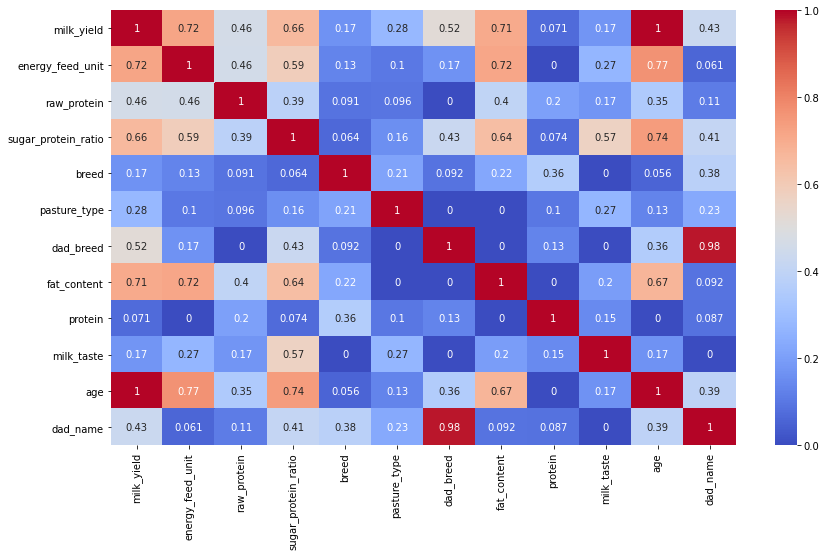

In [ ]:
fig = plt.subplots(figsize=(14, 8))

sns.heatmap(
    ferma_main_for_classification.phik_matrix(interval_cols=['milk_yield', 'energy_feed_unit', \
        'raw_protein', 'sugar_protein_ratio', 'fat_content', 'protein']),
    cmap='coolwarm',
    annot=True,
    fmt='.2g'
)
pass

<div class="alert alert-info">2.09.24: Исправлено ↑

Разделение DataFrame на 2 группы: целевой признак и входные признаки:

In [ ]:
X5 = ferma_main_for_classification.drop('milk_taste', axis=1)

y5 = ferma_main_for_classification['milk_taste']

Разбивка данных для тренировочной и тестовой выборок, <br>
кодирование категориальных признаки с помощью OneHotEncoder,<br>
масштабироване количественных признаков с помощью StandardScaler, <br>
объединение данных в один DataFrame для дальнейшего обучения:

In [ ]:
RANDOM_STATE = 42

X5_train, X5_test, y5_train, y5_test = train_test_split(
    X5,
    y5,
    random_state=RANDOM_STATE,
    stratify=y5
)

y5_train = y5_train.astype('int32')
y5_test = y5_test.astype('int32')

encoder = OneHotEncoder(drop='first', sparse=False)

cat_col_names5 = ['breed', 'pasture_type', 'dad_breed', 'age', 'dad_name']

X5_train_ohe = encoder.fit_transform(X5_train[cat_col_names5])
X5_test_ohe = encoder.transform(X5_test[cat_col_names5])

encoder_col_names5 = encoder.get_feature_names()


scaler = StandardScaler()

num_col_names5 = ['milk_yield', 'energy_feed_unit', 'raw_protein', 'sugar_protein_ratio', 'fat_content', 'protein']

X5_train_scaled = scaler.fit_transform(X5_train[num_col_names5])
X5_test_scaled = scaler.transform(X5_test[num_col_names5])

Объединение данных в один DataFrame для дальнейшего обучения:

In [ ]:
df_X5_train_scaled = pd.DataFrame(X5_train_scaled, columns=num_col_names5)
df_X5_train_ohe = pd.DataFrame(X5_train_ohe, columns=encoder_col_names5)
print('Размер таблицы отмасштабированных признаков:', df_X5_train_scaled.shape)
print('Размер таблицы кодированных признаков:', df_X5_train_ohe.shape)

df_X5_train_merged = df_X5_train_scaled.merge(df_X5_train_ohe, right_index=True, left_index=True)
print('Размер таблицы объединенных признаков:', df_X5_train_merged.shape)

Размер таблицы отмасштабированных признаков: (471, 6)
Размер таблицы кодированных признаков: (471, 7)
Размер таблицы объединенных признаков: (471, 13)


In [ ]:
df_X5_test_scaled = pd.DataFrame(X5_test_scaled, columns=num_col_names5)
df_X5_test_ohe = pd.DataFrame(X5_test_ohe, columns=encoder_col_names5)
print('Размер таблицы отмасштабированных признаков:', df_X5_test_scaled.shape)
print('Размер таблицы кодированных признаков:', df_X5_test_ohe.shape)

df_X5_test_merged = df_X5_test_scaled.merge(df_X5_test_ohe, right_index=True, left_index=True)
print('Размер таблицы объединенных признаков:', df_X5_test_merged.shape)

Размер таблицы отмасштабированных признаков: (158, 6)
Размер таблицы кодированных признаков: (158, 7)
Размер таблицы объединенных признаков: (158, 13)


### 7.2. Обучение модели логистической регрессии

In [ ]:
clf = LogisticRegression()

clf = clf.fit(df_X5_train_merged, y5_train)

y_pred = clf.predict(df_X5_test_merged)

Оцениваем качество модели на тестовой выборке:

In [ ]:
acc = accuracy_score(y5_test, y_pred)
print('Доля верных ответов модели, accuracy:', acc.round(4))

recall = recall_score(y5_test, y_pred)
print('Полнота, recall:', recall.round(4))

precision = precision_score(y5_test, y_pred)
print('Точность, precision:', precision.round(4))

Доля верных ответов модели, accuracy: 0.6329
Полнота, recall: 0.871
Точность, precision: 0.6378


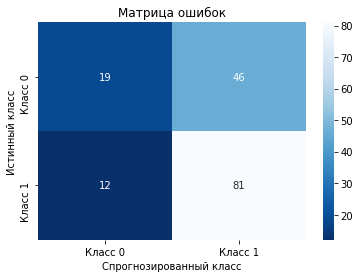

In [ ]:
tick_labels = [f'Класс {i}' for i in range(0,2)]

cm = confusion_matrix(y5_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r', xticklabels=tick_labels, yticklabels=tick_labels)
plt.title('Матрица ошибок')
plt.ylabel('Истинный класс')
plt.xlabel('Спрогнозированный класс')

pass

### 7.3. Анализ модели

Главное для фермера - вкусное молоко. В таком случае первостепенное значение играет снижение ошибки первого рода (FP), т.е. важно, чтобы вероятность присваивания моделью класса 1 (вкусное) классу 0 (невкусное) свелась к минимуму и таким образом фермер  купил корову с невкусным молоком также с наименьшей вероятностью.
За ошибку первого рода отвечает метрика precition.

Создадим таблицу с предсказаниями модели, которые предшествуют определению класса:

In [ ]:
'''
В теоретической части не было полного описания (с кодом), как с помощью кода визуализировать изменение порога.
В интернете нашел такой способ, подкрутив его.
'''
def change_threshold_classifications(X_test, y_test):
    y_proba = pd.DataFrame(clf.predict_proba(X_test))
    thresholds = [round(i,2) for i in np.linspace(0.05, 1, num = 15, endpoint=False)]

    for i in thresholds:
        print ('\n Порог y_pred = {}'.format(i))
        y_test_pred = y_proba.applymap(lambda x: 1 if x>i else 0)

        test_accuracy = accuracy_score(
            y_test.values.reshape(y_test.values.size,1),
            y_test_pred.iloc[:,1].values.reshape(y_test_pred.iloc[:,1].values.size,1)
            )
        print('Доля верных ответов модели, accuracy: {}'.format(test_accuracy.round(4)))

        test_recall = recall_score(
            y_test.values.reshape(y_test.values.size,1),
            y_test_pred.iloc[:,1].values.reshape(y_test_pred.iloc[:,1].values.size,1)
            )
        print('Полнота, recall: {}'.format(test_recall.round(4)))

        test_precision = precision_score(
            y_test.values.reshape(y_test.values.size,1),
            y_test_pred.iloc[:,1].values.reshape(y_test_pred.iloc[:,1].values.size,1)
           )
        print('Точность, precision: {}'.format(test_precision.round(4)))

        print('Матрица ошибок:', '\n',
              confusion_matrix(y_test.values.reshape(y_test.values.size,1),
                               y_test_pred.iloc[:,1].values.reshape(y_test_pred.iloc[:,1].values.size,1))
             )

In [ ]:
change_threshold_classifications(df_X5_test_merged, y5_test)


 Порог y_pred = 0.05
Доля верных ответов модели, accuracy: 0.5886
Полнота, recall: 1.0
Точность, precision: 0.5886
Матрица ошибок: 
 [[ 0 65]
 [ 0 93]]

 Порог y_pred = 0.11
Доля верных ответов модели, accuracy: 0.5886
Полнота, recall: 1.0
Точность, precision: 0.5886
Матрица ошибок: 
 [[ 0 65]
 [ 0 93]]

 Порог y_pred = 0.18
Доля верных ответов модели, accuracy: 0.5886
Полнота, recall: 1.0
Точность, precision: 0.5886
Матрица ошибок: 
 [[ 0 65]
 [ 0 93]]

 Порог y_pred = 0.24
Доля верных ответов модели, accuracy: 0.6076
Полнота, recall: 1.0
Точность, precision: 0.6
Матрица ошибок: 
 [[ 3 62]
 [ 0 93]]

 Порог y_pred = 0.3
Доля верных ответов модели, accuracy: 0.5823
Полнота, recall: 0.957
Точность, precision: 0.5894
Матрица ошибок: 
 [[ 3 62]
 [ 4 89]]

 Порог y_pred = 0.37
Доля верных ответов модели, accuracy: 0.5886
Полнота, recall: 0.9355
Точность, precision: 0.5959
Матрица ошибок: 
 [[ 6 59]
 [ 6 87]]

 Порог y_pred = 0.43
Доля верных ответов модели, accuracy: 0.6076
Полнота, recal

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Пороги с помощью precision_recall_curve:

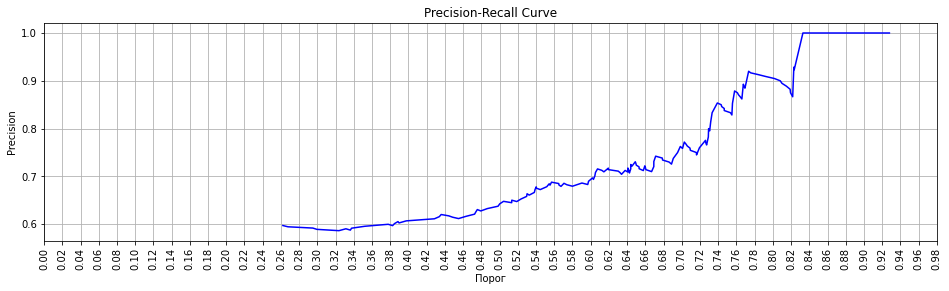

In [ ]:
y_proba = clf.predict_proba(df_X5_test_merged)[:, 1]

precision, recall, thresholds = precision_recall_curve(y5_test, y_proba)

fig, ax = plt.subplots(figsize=(16,4))
ax.plot(thresholds, precision[1:], color='b')
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Порог')
plt.xticks(np.arange(0, 1, 0.02), rotation=90)
plt.grid()

plt.show()

Таким образом, при пороге  классификации y_pred = 0.835 ошибка будет равна 0, при этом точно можно будет выбрать несколько буренок со вкусным молоком.<br>

Метрики изменяются следующим образом: при увеличении порога y_pred уменьшается recall и увеличивается precision.

Получается, что тестовая выборка имеет не очень много значений (158). Также нужно обладать бОльшими знаниями в конкретной сфере, чтобы создавать новые признаки, улучшая качество модели.  

### 7.4. Прогноз вкуса молока коров

#### 7.4.1. Добавление признаков

In [ ]:
cow_buy_for_cl = cow_buy.copy()
cow_buy_for_cl['energy_feed_unit'] = ferma_main['energy_feed_unit'].mean() * 1.05
cow_buy_for_cl['raw_protein'] = ferma_main['raw_protein'].mean() * 1.05
cow_buy_for_cl['sugar_protein_ratio'] = ferma_main['sugar_protein_ratio'].mean() * 1.05

Добавляем предсказанный ранее удой в датафрейм:

In [ ]:
cow_buy_for_cl['milk_yield'] = predictions4
cow_buy_for_cl.head()

,breed,pasture_type,dad_breed,dad_name,fat_content,protein,age,energy_feed_unit,raw_protein,sugar_protein_ratio,milk_yield
0,Айдиал,холмистое,Айдиал,Геркулес,3.580,3.076,более_2_лет,15.271,2019.532,0.959,6542.254
1,Айдиал,равнинное,Соверин,Буйный,3.540,3.081,менее_2_лет,15.271,2019.532,0.959,6295.628
2,Соверин,равнинное,Соверин,Барин,3.590,3.074,более_2_лет,15.271,2019.532,0.959,6257.229
3,Соверин,холмистое,Айдиал,Буйный,3.400,3.061,более_2_лет,15.271,2019.532,0.959,6559.706
4,Соверин,равнинное,Айдиал,Буйный,3.640,3.074,более_2_лет,15.271,2019.532,0.959,6500.623


In [ ]:
cow_buy_for_cl.reindex(columns=['milk_yield', 'energy_feed_unit', 'raw_protein', 'sugar_protein_ratio', 'breed', 'pasture_type', 'dad_breed', 'fat_content', 'protein', 'age', 'dad_name']).head()

,milk_yield,energy_feed_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat_content,protein,age,dad_name
0,6542.254,15.271,2019.532,0.959,Айдиал,холмистое,Айдиал,3.580,3.076,более_2_лет,Геркулес
1,6295.628,15.271,2019.532,0.959,Айдиал,равнинное,Соверин,3.540,3.081,менее_2_лет,Буйный
2,6257.229,15.271,2019.532,0.959,Соверин,равнинное,Соверин,3.590,3.074,более_2_лет,Барин
3,6559.706,15.271,2019.532,0.959,Соверин,холмистое,Айдиал,3.400,3.061,более_2_лет,Буйный
4,6500.623,15.271,2019.532,0.959,Соверин,равнинное,Айдиал,3.640,3.074,более_2_лет,Буйный


#### 7.4.2. Подготовка данных:

In [ ]:
X6_test_ohe = encoder.transform(cow_buy_for_cl[cat_col_names5])

encoder_col_names5 = encoder.get_feature_names()

X6_test_scaled = scaler.transform(cow_buy_for_cl[num_col_names5])

Объединение данных в один DataFrame для дальнейшего обучения:

In [ ]:
print('Размер таблицы отмасштабированных признаков:', df_X5_train_scaled.shape)
print('Размер таблицы кодированных признаков:', df_X5_train_ohe.shape)

print('Размер таблицы объединенных признаков:', df_X5_train_merged.shape)

Размер таблицы отмасштабированных признаков: (471, 6)
Размер таблицы кодированных признаков: (471, 7)
Размер таблицы объединенных признаков: (471, 13)


In [ ]:
df_X6_test_scaled = pd.DataFrame(X6_test_scaled, columns=num_col_names5)

df_X6_test_ohe = pd.DataFrame(X6_test_ohe, columns=encoder_col_names5)

print('Размер таблицы отмасштабированных признаков:', df_X6_test_scaled.shape)
print('Размер таблицы кодированных признаков:', df_X6_test_ohe.shape)

df_X6_test_merged = df_X6_test_scaled.merge(df_X6_test_ohe, right_index=True, left_index=True)
print('Размер таблицы объединенных признаков:', df_X6_test_merged.shape)

Размер таблицы отмасштабированных признаков: (16, 6)
Размер таблицы кодированных признаков: (16, 7)
Размер таблицы объединенных признаков: (16, 13)


#### 7.4.3. Получение прогноза вкуса молока

In [ ]:
clf = LogisticRegression()

clf = clf.fit(df_X5_train_merged, y5_train)

y_pred = clf.predict(df_X6_test_merged)

In [ ]:
y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1], dtype=int32)

Прогнозные данные с учетом вероятностей:

In [ ]:
y_proba_end = pd.DataFrame(clf.predict_proba(df_X6_test_merged))
y_proba_end['y_pred'] = y_pred
y_proba_end.sort_values(by=1, ascending=False)

,0,1,y_pred
11,0.161,0.839,1
7,0.179,0.821,1
1,0.203,0.797,1
6,0.213,0.787,1
0,0.223,0.777,1
13,0.232,0.768,1
2,0.308,0.692,1
15,0.328,0.672,1
12,0.354,0.646,1
4,0.372,0.628,1


Т.о. с учетом выбранного порога классификации фермер может выбрать 1 из 16 коров: с индексом 11.

При y_pred = 0.75 ошибка первого рода - минимальна, можно выбрать несколько буренок со вкусным молоком, но это будет лишь 1,3% от всех коров; но precition уже ниже, чем в y_pred = 0.68; <br>
при пороге y_pred = 0.68 - ошибка первого рода возрастает, но можно отобрать 13,9% от всех коров.

In [ ]:
y_proba_end = pd.DataFrame(clf.predict_proba(df_X6_test_merged))
y_proba_end['y_pred'] = y_pred
y_proba_end.sort_values(by=1, ascending=False)

,0,1,y_pred
11,0.161,0.839,1
7,0.179,0.821,1
1,0.203,0.797,1
6,0.213,0.787,1
0,0.223,0.777,1
13,0.232,0.768,1
2,0.308,0.692,1
15,0.328,0.672,1
12,0.354,0.646,1
4,0.372,0.628,1


Т.о. с учетом выбранного порога классификации фермер может выбрать 2 из 16 коров: с индексами 13 и 0.

### 7.5. Выводы

В данном разделе была создана модель классификации для прогноза вкуса молока.<br>
Вкус молока - основной критерий для Заказчика, поэтому в качестве основной метрики выбран precition.<br>
В результате моделирования был установлен порог классификации y_pred = 0.835, при котором ошибка первого рода равна 0, но при этом True Positive варианты также существуют.

Получаем, что при выбранном пороге классификации фермер может отобрать 1 из 16 коров 'ЭкоФермы' (с индексом 11).

## 8. Итоговые выводы

Добавим прогнозы вкуса молока и удоя коров «ЭкоФермы» в датафрейм с коровами, покупку которых рассматривает фермер:

In [ ]:
cow_buy['milk_yield'] = predictions4
cow_buy['milk_taste'] = y_pred
cow_buy.head(20)

,breed,pasture_type,dad_breed,dad_name,fat_content,protein,age,milk_yield,milk_taste
0,Айдиал,холмистое,Айдиал,Геркулес,3.580,3.076,более_2_лет,6542.254,1
1,Айдиал,равнинное,Соверин,Буйный,3.540,3.081,менее_2_лет,6295.628,1
2,Соверин,равнинное,Соверин,Барин,3.590,3.074,более_2_лет,6257.229,1
3,Соверин,холмистое,Айдиал,Буйный,3.400,3.061,более_2_лет,6559.706,1
4,Соверин,равнинное,Айдиал,Буйный,3.640,3.074,более_2_лет,6500.623,1
5,Соверин,равнинное,Соверин,Геркулес,3.630,3.053,менее_2_лет,6278.176,0
7,Айдиал,равнинное,Соверин,Буйный,3.570,3.079,более_2_лет,6511.754,1
9,Соверин,холмистое,Айдиал,Буйный,3.400,3.079,менее_2_лет,6343.581,1
10,Айдиал,холмистое,Соверин,Соловчик,3.730,3.055,более_2_лет,6372.155,0
11,Соверин,равнинное,Соверин,Геркулес,3.730,3.073,более_2_лет,6494.302,1


Отбер коров, для которых спрогнозирован удой более 6000 килограммов в год и вкусное молоко:

In [ ]:
cow_buy.query('milk_yield > 6000 and index == [11]')

,breed,pasture_type,dad_breed,dad_name,fat_content,protein,age,milk_yield,milk_taste
11,Соверин,равнинное,Соверин,Геркулес,3.730,3.073,более_2_лет,6494.302,1


Таким образом, фермер может купить 1 корову с вкусным молоком и удоем более 6 000 кг (и удоем, попадающим в доверительный интервал) с минимальным риском для себя. <br>
Требуемый удой прогнозируется более, чем для 2 коров, однако модель классификации уменьшила выборку исходя из вкуса молока и условия, что 'лучше фермер не купит корову со вкусным молоком (TP), чем купит корову с не вкусным молоком (FP)'.

Для лучшего прогнозирования модели классификации требуются реальные данные о Сахаро-протеиновом отношении (СПО), т.к. этот признак сильнее остальных влияет на вкус молока, а также ЭКЕ и Сырой протеин.

**Выводы о моделях линейной регрессии и логистической регрессии:**


Для улучшения качества моделей линейной регрессии произведены следующие действия:<br>
- определены входные признаки, имеющие наибольшую линейную связь с целевым (с учетом подгрупп входных признаков);
- устранены лишние признаки;
- устранена нелинейность между целевым и входными признаками;
- видоизменены имеющиеся признаки;
- добавлены новые признаки;
- масштабированы количественные, закодированы качественные признаки.


Улучить качество модели можно:
- погрузившись в сферу и выяснив ее специфические детали для более точной настройки модели;
- увеличив размер исходных данных, особенно выборки, для которой нужно сделать прогноз;
- уточнить признаки в данных cow_buy (СПО, ЭКЕ, Сырой протеин);

Выбор метрики для моделей классификации зависит от конкретной задачи бизнеса. При необходимости не допустить ошибку первого рода (FP) выбирают precition, при необходимости не допустить ошибку второго рода - recall.<br>
Оценивая риск, например, отнести человека к классу 'террорист' или 'не террорист', лучше сделать ложноположительную оценку (FP) и проверить не террориста на наличие оружия, чем совершить ложноотрицательную оценку (FN) и пропустить человека с бомбой. ЗДесь выбираем метрику precition.